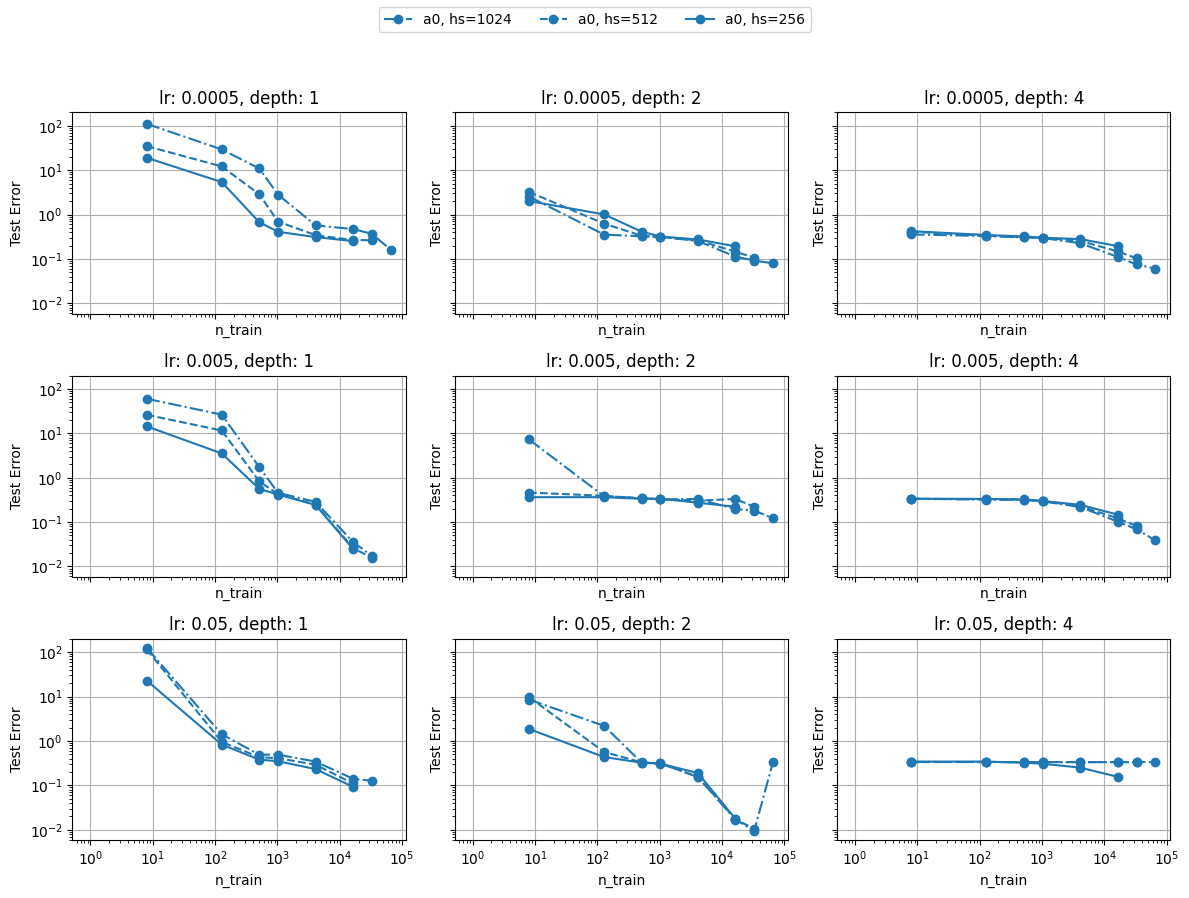

In [7]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_mup_depth_1"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


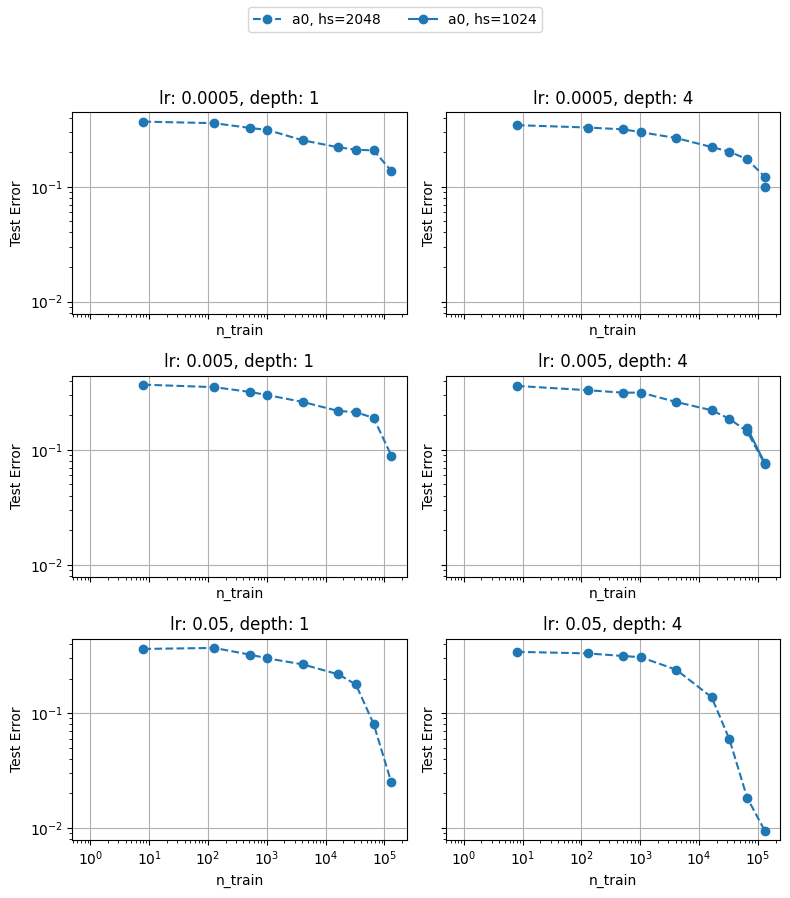

In [6]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_standard_depth_mpi"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


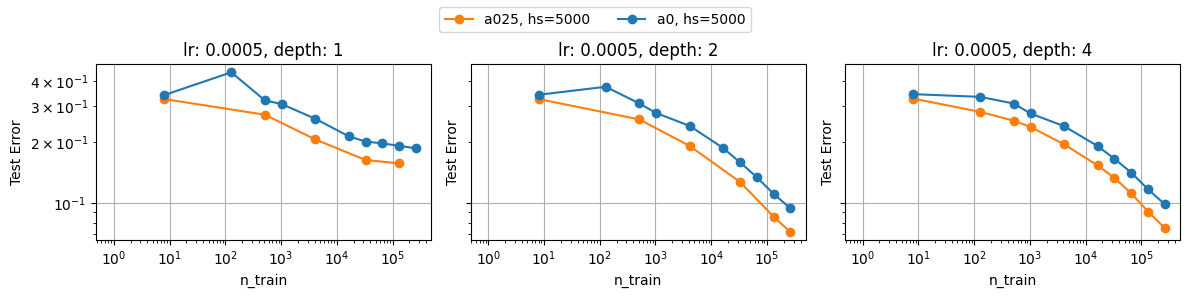

In [8]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d50_hidden512_NTKjax_depth_1"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


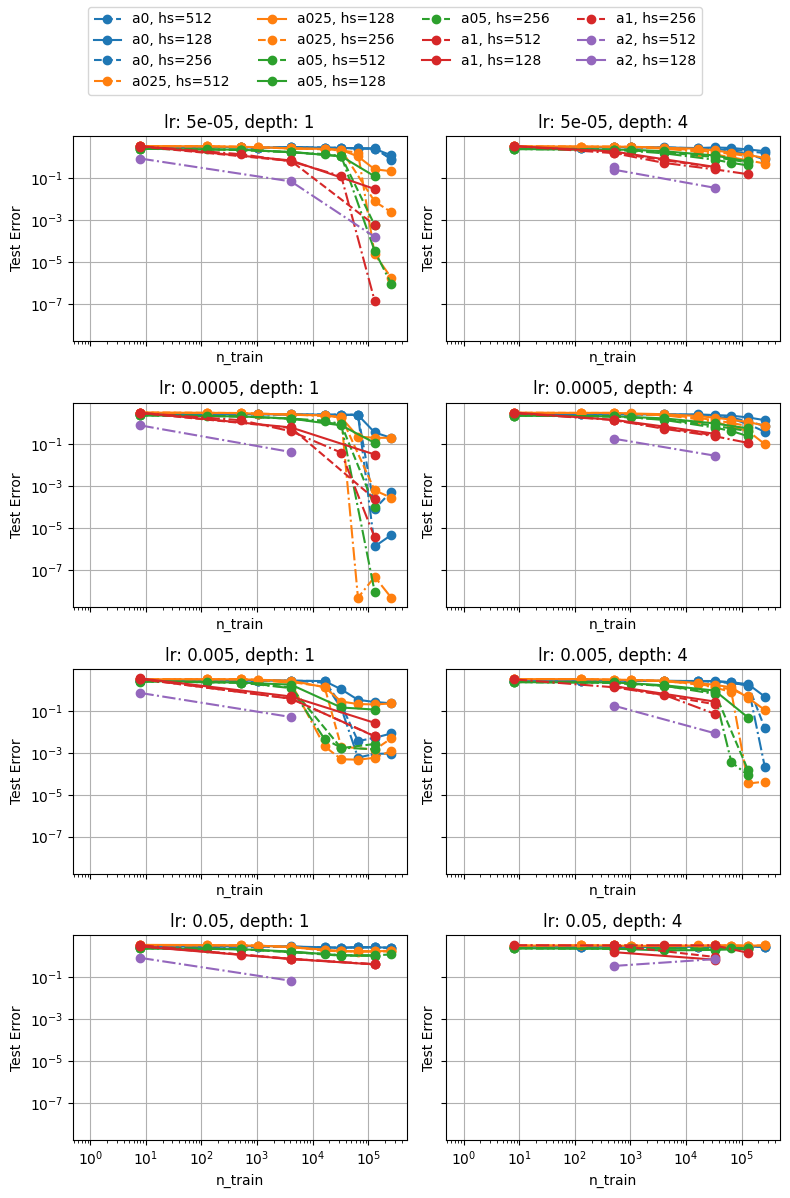

In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


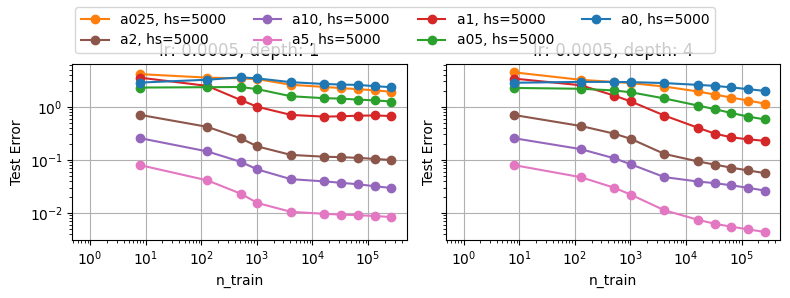

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_NTK_2102_maxiter20k"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "*_results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


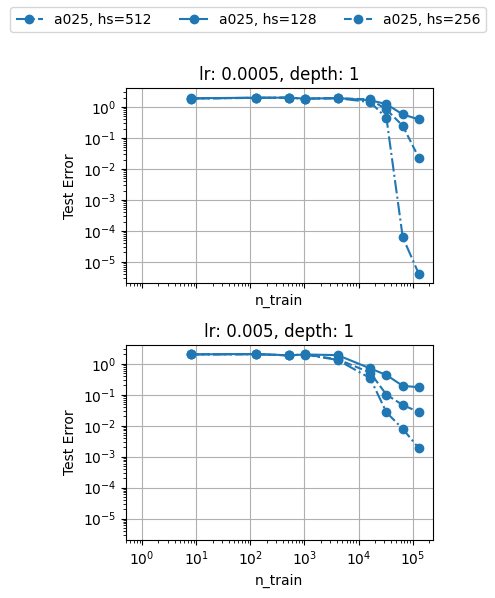

In [3]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d10_hidden256_pytorch_2202_loss"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
depth_set = set()
dataset_set = set()
hidden_size_set = set()

for r in results:
    try:
        lr_set.add(r["learning_rate"])
        depth_set.add(r["depth"])
        dataset_set.add(r["dataset_name"])
        hidden_size_set.add(r["hidden_size"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_depth = sorted(depth_set)
unique_dataset = sorted(dataset_set)
unique_hidden = sorted(hidden_size_set)

# ======= MAP HIDDEN SIZE TO LINE STYLE =======
line_styles = ['-', '--', '-.', ':']
hidden_line_styles = {}
for i, hs in enumerate(unique_hidden):
    hidden_line_styles[hs] = line_styles[i % len(line_styles)]
    
# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]
    
# ======= GROUP DATA =======
# Structure: group_data[learning_rate][depth][(dataset_name, hidden_size)][n_train] = list of test_error values.
group_data = {}
for lr in unique_lr:
    group_data[lr] = {}
    for depth in unique_depth:
         group_data[lr][depth] = {}

for r in results:
    try:
        lr = r["learning_rate"]
        depth = r["depth"]
        dataset = r["dataset_name"]
        hs = r["hidden_size"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
         print(f"Skipping result due to missing key: {e}")
         continue

    key = (dataset, hs)
    if key not in group_data[lr][depth]:
         group_data[lr][depth][key] = {}
    if n_train not in group_data[lr][depth][key]:
         group_data[lr][depth][key][n_train] = []
    group_data[lr][depth][key][n_train].append(test_error)
    
# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = learning rates, columns = depths.
n_rows = len(unique_lr)
n_cols = len(unique_depth)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])
    
# For global legend handles.
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, depth in enumerate(unique_depth):
        ax = axes[i, j]
        data_dict = group_data[lr][depth]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each (dataset, hidden_size) group in this subplot.
        for key, ntrain_dict in data_dict.items():
            dataset, hs = key
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            ls = hidden_line_styles[hs]
            color = dataset_colors[dataset]
            line = ax.errorbar(x_vals, y_means, yerr=y_stds, 
                               linestyle=ls, marker='o', color=color, label=f"{dataset}, hs={hs}")[0]
            legend_key = f"{dataset}, hs={hs}"
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"lr: {lr}, depth: {depth}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


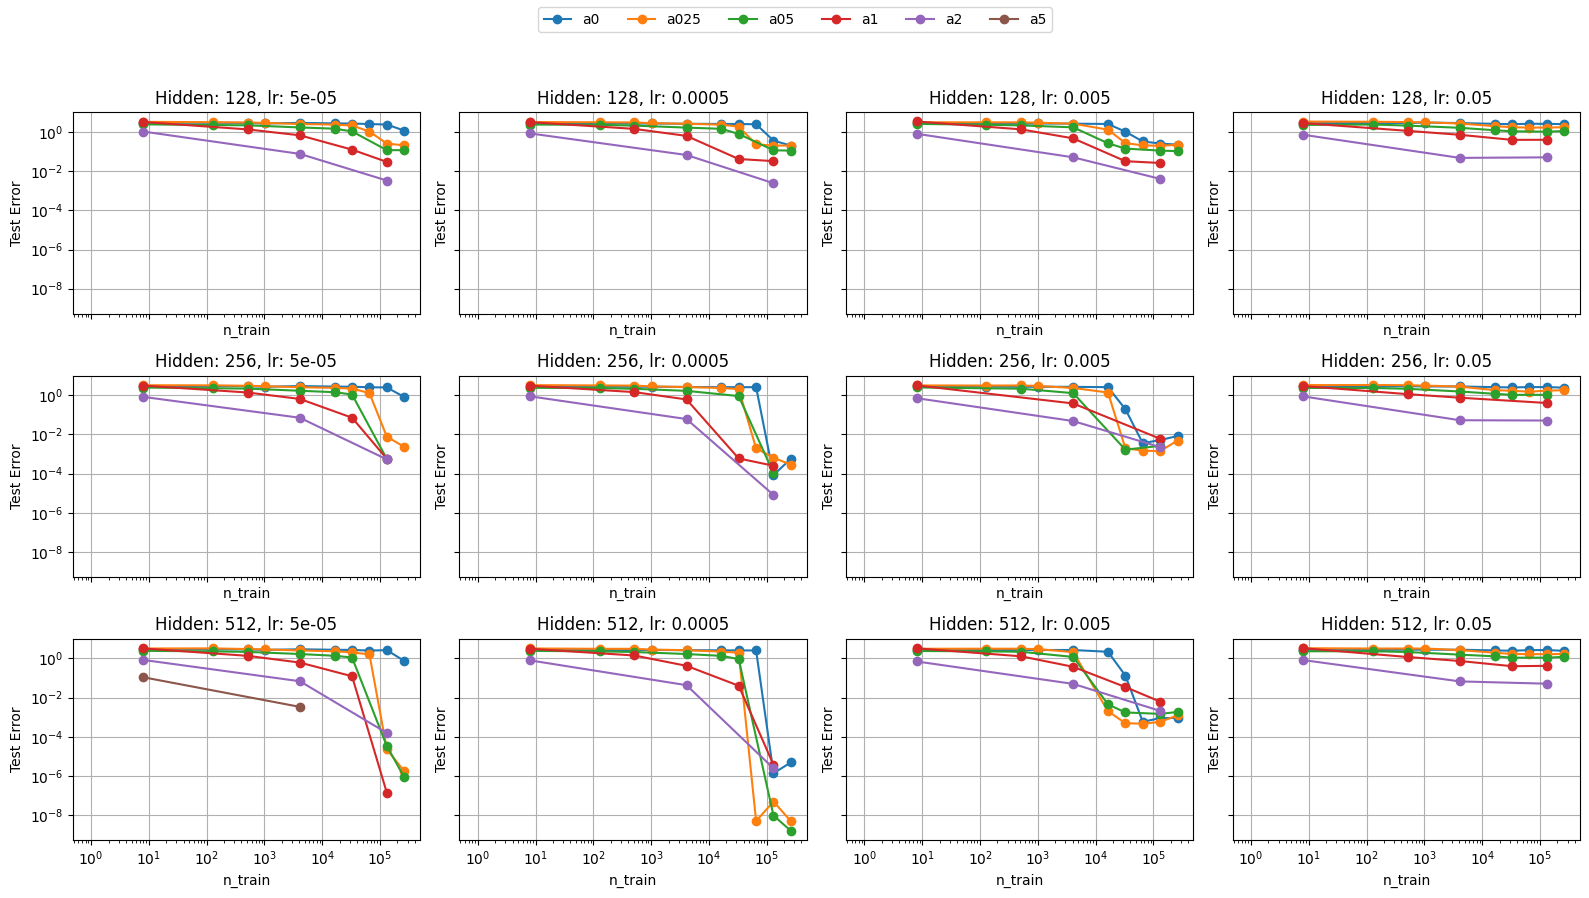

Plot data saved to plot_data.json


In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"
# File path to save the plot data (JSON)
plot_data_file = "plot_data.json"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern "results_*.jsonl".
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS AND COLLECT PLOT DATA =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# This list will hold the plot data.
plot_data = []

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line

            # Save this curve's data.
            curve_data = {
                "hidden_size": hs,
                "learning_rate": lr,
                "dataset": dataset,
                "n_train": x_vals,
                "mean_test_error": y_means,
                "std_test_error": y_stds
            }
            plot_data.append(curve_data)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {plot_data_file}")


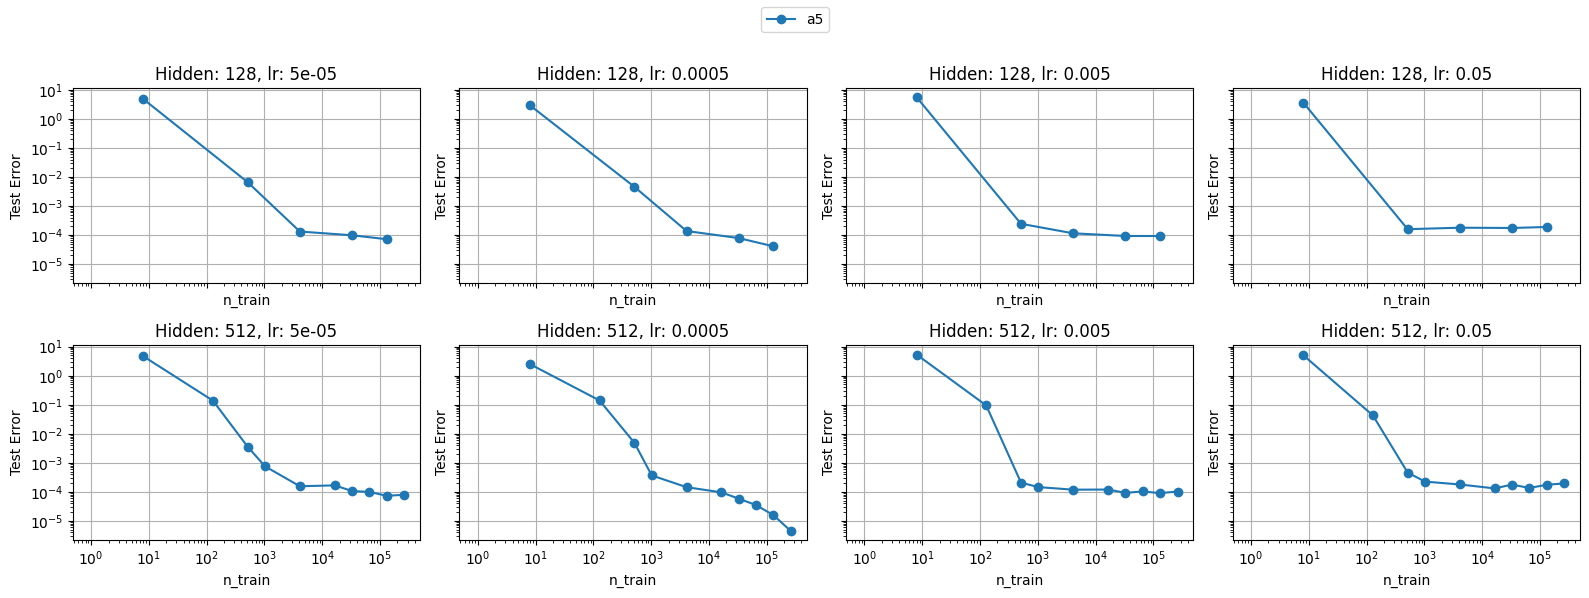

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d10_hidden256_pytorch_2302_biggrid"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


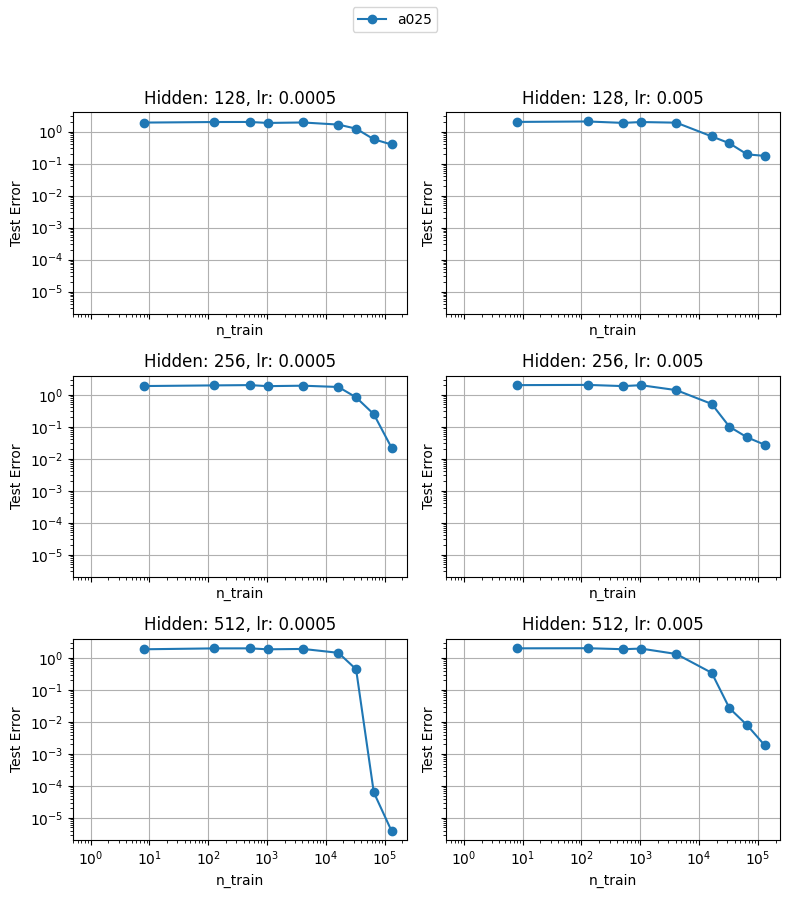

NN learning rates: [5e-05, 0.0005, 0.005, 0.05]
NN hidden sizes: [128, 256, 512]
Common datasets: ['a0', 'a025', 'a05', 'a1', 'a2']


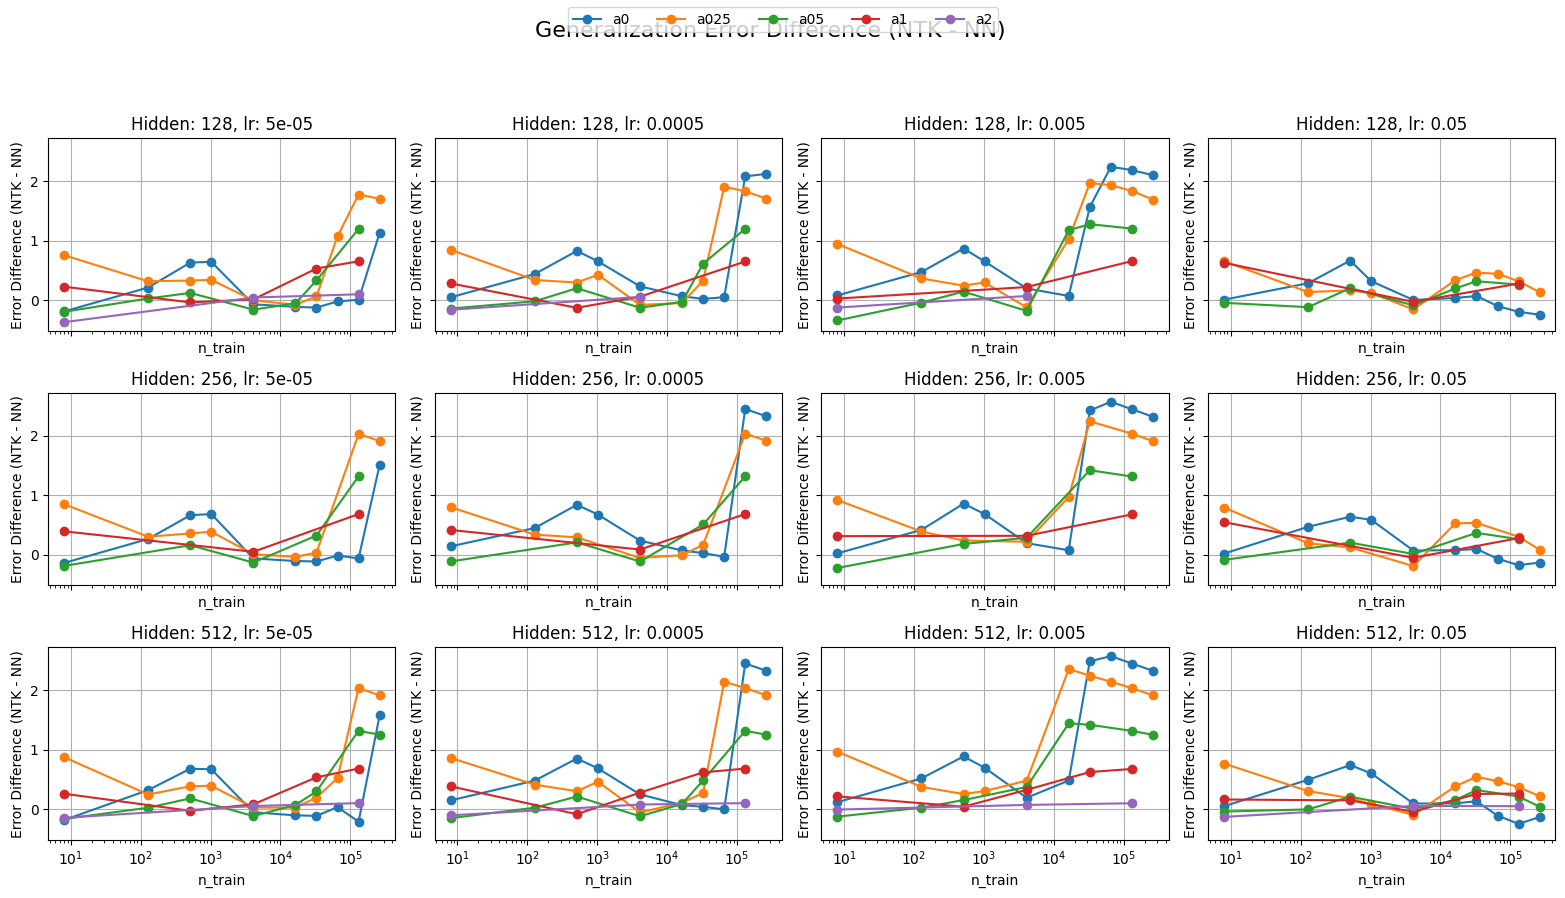

Plot data saved to plot_data.json


In [26]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# NN (baseline) results directory
results_directory_nn = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# NTK results directory (kernels do not vary in lr or width)
results_directory_ntk = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_NTK_2102_maxiter20k"
# Save figure? If not, leave empty.
save_fig_path = ""  # e.g., "my_plot.png"
# Save plot data (x and y values with hyperparameters) as JSON:
save_data_path = "plot_data.json"  # change this if needed

# ======= LOAD RESULTS FUNCTION =======
def load_results(directory, pattern_suffix):
    """
    Load all JSON Lines files in the directory that match the given pattern.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, pattern_suffix)
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# ======= LOAD NN and NTK RESULTS =======
# Use the NN pattern (e.g., "results_*.jsonl")
results_nn = load_results(results_directory_nn, pattern_suffix="results_*.jsonl")
# Use the NTK pattern (e.g., "*_results_*.jsonl")
results_ntk = load_results(results_directory_ntk, pattern_suffix="*_results_*.jsonl")

if not results_nn:
    print("No NN results loaded. Please check the NN directory path.")
if not results_ntk:
    print("No NTK results loaded. Please check the NTK directory path.")

# ======= FILTER FOR DEPTH‑1 NETWORKS =======
results_nn_depth1 = [r for r in results_nn if r.get("depth") == 1]
results_ntk_depth1 = [r for r in results_ntk if r.get("depth") == 1]

# ======= IDENTIFY PARAMETERS FROM NN RESULTS =======
# For NN, we want to plot a grid in terms of hidden size and learning rate.
lr_set_nn = set()
hidden_set_nn = set()
dataset_set_nn = set()
for r in results_nn_depth1:
    try:
        lr_set_nn.add(r["learning_rate"])
        hidden_set_nn.add(r["hidden_size"])
        dataset_set_nn.add(r["dataset_name"])
    except KeyError:
        continue

unique_lr_nn = sorted(lr_set_nn)
unique_hidden_nn = sorted(hidden_set_nn)
# For datasets, use the intersection of NN and NTK datasets.
dataset_set_ntk = set(r["dataset_name"] for r in results_ntk_depth1 if "dataset_name" in r)
common_datasets = sorted(dataset_set_nn.intersection(dataset_set_ntk))

print("NN learning rates:", unique_lr_nn)
print("NN hidden sizes:", unique_hidden_nn)
print("Common datasets:", common_datasets)

# ======= GROUP NN RESULTS =======
# Group by: group_nn[hidden_size][lr][dataset][n_train] = list of test_error values
def group_results_nn(results):
    group = {}
    for r in results:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        if hs not in group:
            group[hs] = {}
        if lr not in group[hs]:
            group[hs][lr] = {}
        if ds not in group[hs][lr]:
            group[hs][lr][ds] = {}
        if n_train not in group[hs][lr][ds]:
            group[hs][lr][ds][n_train] = []
        group[hs][lr][ds][n_train].append(test_error)
    return group

group_nn = group_results_nn(results_nn_depth1)

# ======= GROUP NTK RESULTS (Ignoring lr and width) =======
# Group by: group_ntk[dataset][n_train] = list of test_error values, then average them.
def group_results_ntk(results):
    group = {}
    for r in results:
        try:
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        if ds not in group:
            group[ds] = {}
        if n_train not in group[ds]:
            group[ds][n_train] = []
        group[ds][n_train].append(test_error)
    # Average multiple entries.
    for ds in group:
        for n in group[ds]:
            group[ds][n] = sum(group[ds][n]) / len(group[ds][n])
    return group

group_ntk = group_results_ntk(results_ntk_depth1)

# ======= SET UP COLORS FOR DATASETS =======
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(common_datasets):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= PLOT THE DIFFERENCE (NTK - NN) AND COLLECT PLOT DATA =======
# The grid is defined by NN hidden sizes (rows) and learning rates (columns).
n_rows = len(unique_hidden_nn)
n_cols = len(unique_lr_nn)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# This list will hold our plot data.
plot_data = []

for i, hs in enumerate(unique_hidden_nn):
    for j, lr in enumerate(unique_lr_nn):
        ax = axes[i, j]
        # Check if NN results exist for this configuration.
        if hs not in group_nn or lr not in group_nn[hs]:
            ax.set_visible(False)
            continue
        # For each dataset (e.g. a0, a025, etc.)
        for ds in common_datasets:
            if ds not in group_nn[hs][lr]:
                continue
            nn_data = group_nn[hs][lr][ds]  # { n_train: list of NN test errors }
            # Average NN test errors for each n_train.
            nn_avg = {n: sum(vals)/len(vals) for n, vals in nn_data.items()}
            # For NTK, use the grouped result (already averaged) for this dataset.
            if ds not in group_ntk:
                continue
            ntk_data = group_ntk[ds]  # { n_train: averaged NTK test error }
            # Find common training sizes.
            common_n_train = sorted(set(nn_avg.keys()).intersection(ntk_data.keys()))
            if not common_n_train:
                continue
            x_vals = common_n_train
            diff_vals = [ntk_data[n] - nn_avg[n] for n in x_vals]
            ax.plot(x_vals, diff_vals, marker='o', linestyle='-',
                    color=dataset_colors[ds], label=ds)
            # Save this curve's data
            curve_data = {
                "hidden_size": hs,
                "learning_rate": lr,
                "dataset": ds,
                "n_train": x_vals,
                "error_diff": diff_vals
            }
            plot_data.append(curve_data)
        ax.set_xscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Error Difference (NTK - NN)")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend using proxy artists.
proxy_handles = [Line2D([0], [0], marker='o', color=dataset_colors[ds],
                        linestyle='-') for ds in common_datasets]
fig.legend(proxy_handles, common_datasets, loc="upper center", ncol=len(common_datasets))
fig.suptitle("Generalization Error Difference (NTK - NN)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.93])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(save_data_path, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {save_data_path}")


NN learning rates: [5e-05, 0.0005, 0.005, 0.05]
NN hidden sizes: [128, 256, 512]
Common datasets: ['a0', 'a025', 'a05', 'a1', 'a2', 'a5']


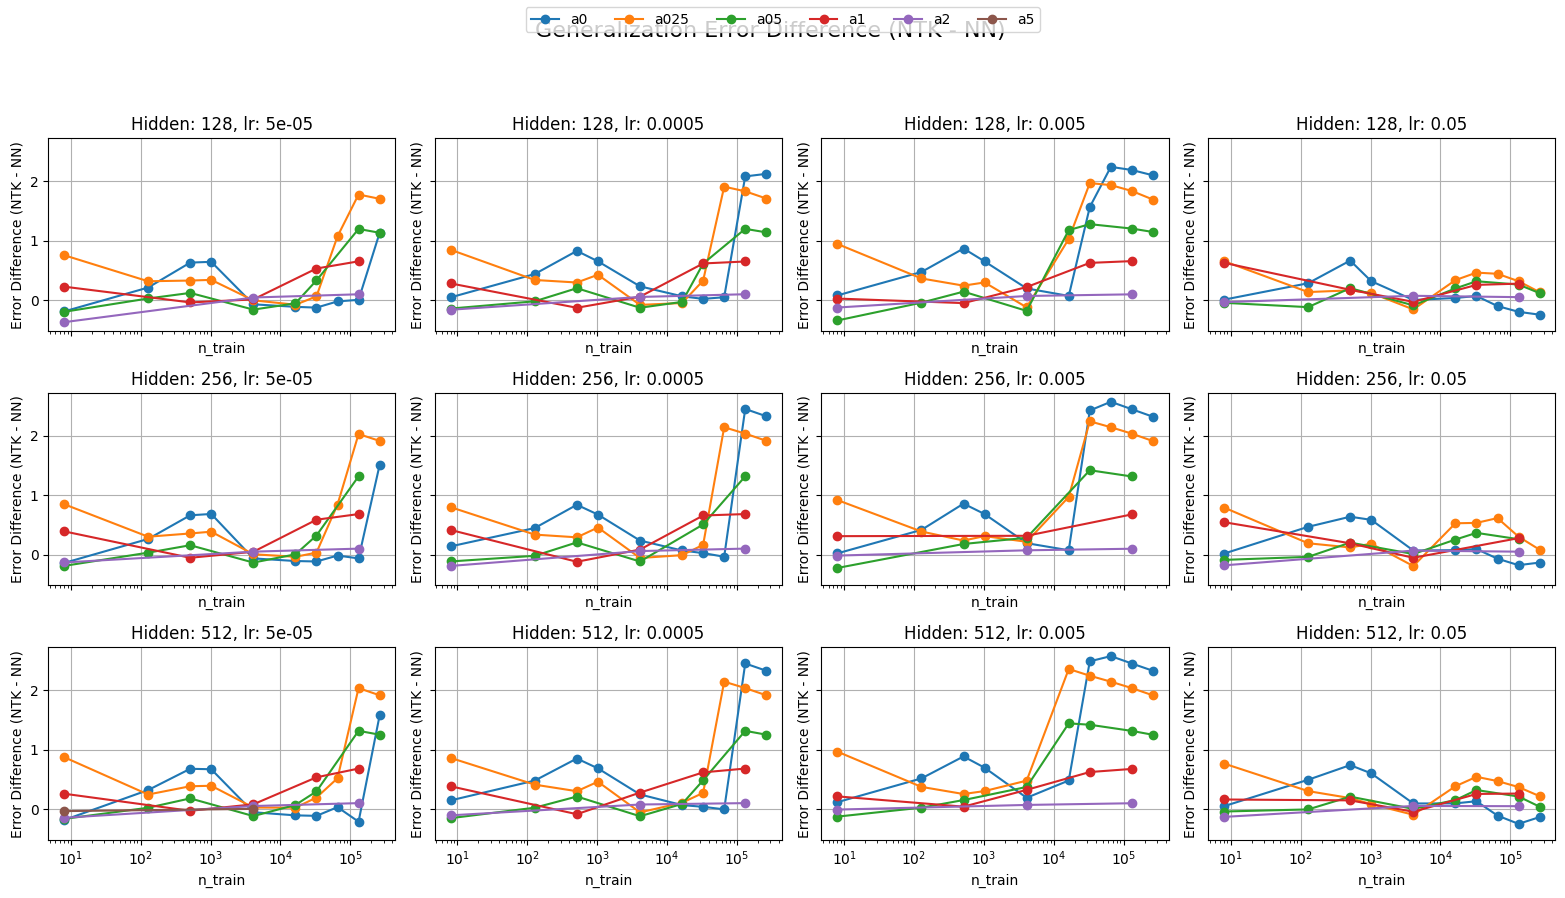

Plot data saved to plot_data.json


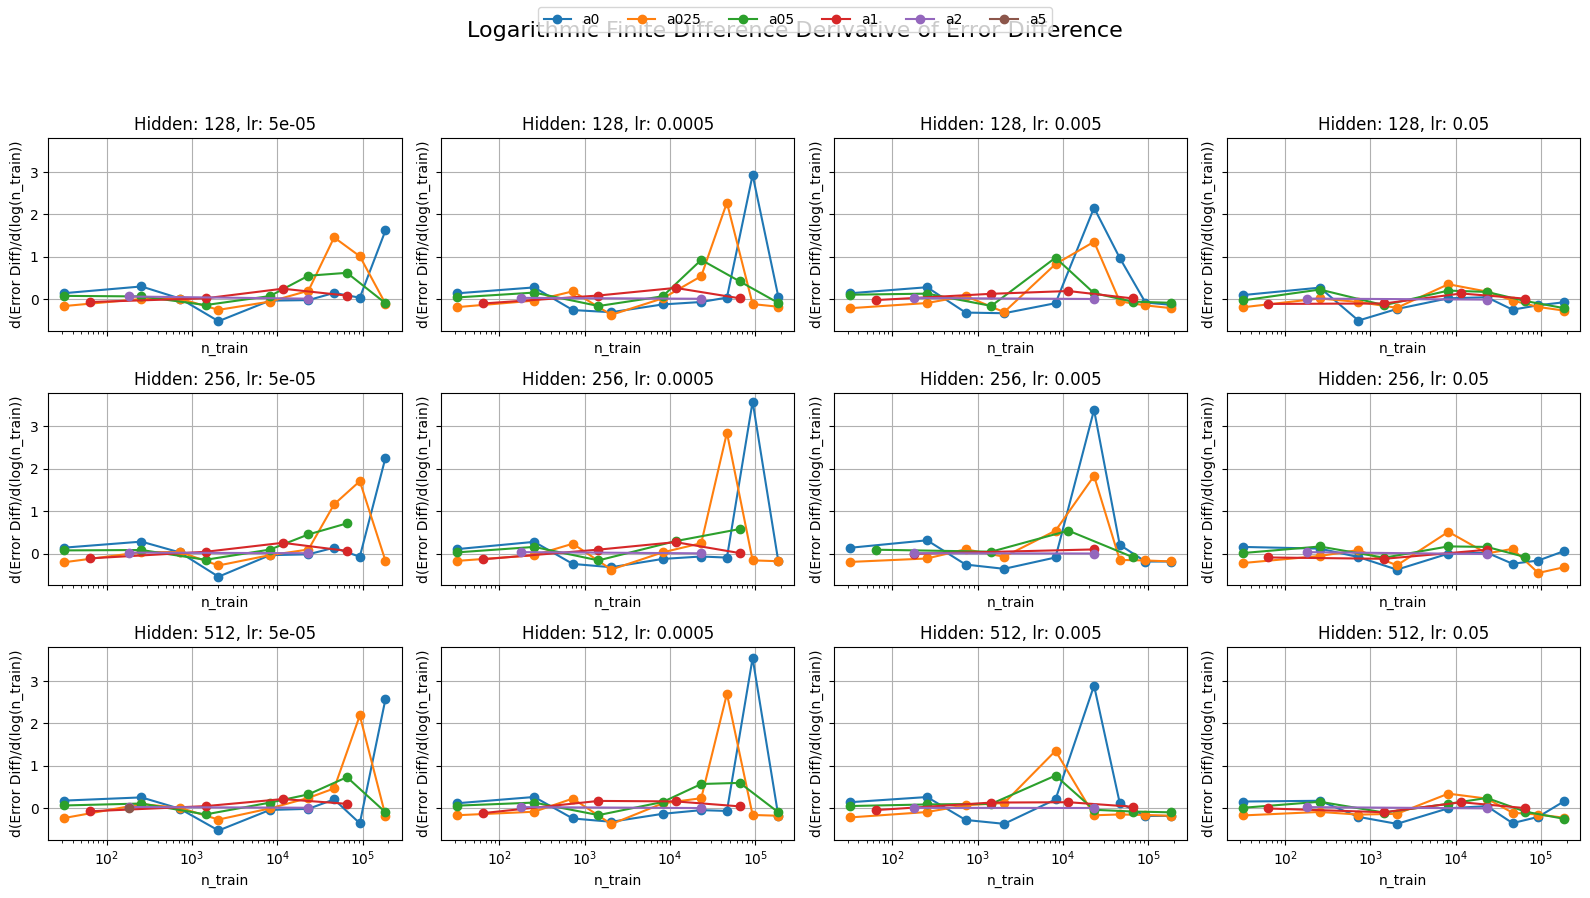

In [3]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# NN (baseline) results directory
results_directory_nn = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_pytorch_2102_biggrid"
# NTK results directory (kernels do not vary in lr or width)
results_directory_ntk = "/home/goring/TF_spectrum/results_testgrid/d30_hidden256_NTK_2102_maxiter20k"
# Save figure? If not, leave empty.
save_fig_path = ""  # e.g., "my_plot.png"
# Save plot data (x and y values with hyperparameters) as JSON:
save_data_path = "plot_data.json"  # change this if needed

# ======= LOAD RESULTS FUNCTION =======
def load_results(directory, pattern_suffix):
    """
    Load all JSON Lines files in the directory that match the given pattern.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, pattern_suffix)
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# ======= LOAD NN and NTK RESULTS =======
results_nn = load_results(results_directory_nn, pattern_suffix="results_*.jsonl")
results_ntk = load_results(results_directory_ntk, pattern_suffix="*_results_*.jsonl")

if not results_nn:
    print("No NN results loaded. Please check the NN directory path.")
if not results_ntk:
    print("No NTK results loaded. Please check the NTK directory path.")

# ======= FILTER FOR DEPTH‑1 NETWORKS =======
results_nn_depth1 = [r for r in results_nn if r.get("depth") == 1]
results_ntk_depth1 = [r for r in results_ntk if r.get("depth") == 1]

# ======= IDENTIFY PARAMETERS FROM NN RESULTS =======
lr_set_nn = set()
hidden_set_nn = set()
dataset_set_nn = set()
for r in results_nn_depth1:
    try:
        lr_set_nn.add(r["learning_rate"])
        hidden_set_nn.add(r["hidden_size"])
        dataset_set_nn.add(r["dataset_name"])
    except KeyError:
        continue

unique_lr_nn = sorted(lr_set_nn)
unique_hidden_nn = sorted(hidden_set_nn)
# For datasets, use the intersection of NN and NTK datasets.
dataset_set_ntk = set(r["dataset_name"] for r in results_ntk_depth1 if "dataset_name" in r)
common_datasets = sorted(dataset_set_nn.intersection(dataset_set_ntk))

print("NN learning rates:", unique_lr_nn)
print("NN hidden sizes:", unique_hidden_nn)
print("Common datasets:", common_datasets)

# ======= GROUP NN RESULTS =======
# Group by: group_nn[hidden_size][lr][dataset][n_train] = list of test_error values
def group_results_nn(results):
    group = {}
    for r in results:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        group.setdefault(hs, {}).setdefault(lr, {}).setdefault(ds, {}).setdefault(n_train, []).append(test_error)
    return group

group_nn = group_results_nn(results_nn_depth1)

# ======= GROUP NTK RESULTS (Ignoring lr and width) =======
# Group by: group_ntk[dataset][n_train] = list of test_error values, then average them.
def group_results_ntk(results):
    group = {}
    for r in results:
        try:
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError:
            continue
        group.setdefault(ds, {}).setdefault(n_train, []).append(test_error)
    # Average multiple entries.
    for ds in group:
        for n in group[ds]:
            group[ds][n] = sum(group[ds][n]) / len(group[ds][n])
    return group

group_ntk = group_results_ntk(results_ntk_depth1)

# ======= SET UP COLORS FOR DATASETS =======
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {ds: default_colors[i % len(default_colors)] for i, ds in enumerate(common_datasets)}

# ======= PLOT THE DIFFERENCE (NTK - NN) AND COLLECT PLOT DATA =======
n_rows = len(unique_hidden_nn)
n_cols = len(unique_lr_nn)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

plot_data = []

for i, hs in enumerate(unique_hidden_nn):
    for j, lr in enumerate(unique_lr_nn):
        ax = axes[i, j]
        if hs not in group_nn or lr not in group_nn[hs]:
            ax.set_visible(False)
            continue
        for ds in common_datasets:
            if ds not in group_nn[hs][lr]:
                continue
            nn_data = group_nn[hs][lr][ds]
            nn_avg = {n: sum(vals) / len(vals) for n, vals in nn_data.items()}
            if ds not in group_ntk:
                continue
            ntk_data = group_ntk[ds]
            common_n_train = sorted(set(nn_avg.keys()).intersection(ntk_data.keys()))
            if not common_n_train:
                continue
            x_vals = common_n_train
            diff_vals = [ntk_data[n] - nn_avg[n] for n in x_vals]
            ax.plot(x_vals, diff_vals, marker='o', linestyle='-',
                    color=dataset_colors[ds], label=ds)
            curve_data = {
                "hidden_size": hs,
                "learning_rate": lr,
                "dataset": ds,
                "n_train": x_vals,
                "error_diff": diff_vals
            }
            plot_data.append(curve_data)
        ax.set_xscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Error Difference (NTK - NN)")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

proxy_handles = [Line2D([0], [0], marker='o', color=dataset_colors[ds], linestyle='-') for ds in common_datasets]
fig.legend(proxy_handles, common_datasets, loc="upper center", ncol=len(common_datasets))
fig.suptitle("Generalization Error Difference (NTK - NN)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.93])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

with open(save_data_path, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {save_data_path}")

# ======= PLOT THE FIRST DERIVATIVE OF THE CURVES USING LOGARITHMIC FINITE DIFFERENCES =======
fig_deriv, axes_deriv = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes_deriv is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes_deriv = np.array([[axes_deriv]])
elif n_rows == 1:
    axes_deriv = np.array([axes_deriv])
elif n_cols == 1:
    axes_deriv = np.array([[ax] for ax in axes_deriv])

for i, hs in enumerate(unique_hidden_nn):
    for j, lr in enumerate(unique_lr_nn):
        ax = axes_deriv[i, j]
        if hs not in group_nn or lr not in group_nn[hs]:
            ax.set_visible(False)
            continue
        for ds in common_datasets:
            if ds not in group_nn[hs][lr]:
                continue
            nn_data = group_nn[hs][lr][ds]
            nn_avg = {n: sum(vals) / len(vals) for n, vals in nn_data.items()}
            if ds not in group_ntk:
                continue
            ntk_data = group_ntk[ds]
            common_n_train = sorted(set(nn_avg.keys()).intersection(ntk_data.keys()))
            if not common_n_train or len(common_n_train) < 2:
                continue
            x_vals = common_n_train
            diff_vals = [ntk_data[n] - nn_avg[n] for n in x_vals]
            # Compute logarithmic finite difference derivative manually.
            x_arr = np.array(x_vals, dtype=float)
            f_arr = np.array(diff_vals, dtype=float)
            deriv = []
            x_mid = []
            for k in range(len(x_arr) - 1):
                # Compute derivative with respect to log(x)
                dx_log = np.log(x_arr[k+1]) - np.log(x_arr[k])
                df = f_arr[k+1] - f_arr[k]
                deriv.append(df/dx_log)
                # x coordinate as the geometric mean (midpoint in log-space)
                x_mid.append(np.exp((np.log(x_arr[k+1]) + np.log(x_arr[k]))/2))
            ax.plot(x_mid, deriv, marker='o', linestyle='-',
                    color=dataset_colors[ds], label=ds)
        ax.set_xscale("log")
        #ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("d(Error Diff)/d(log(n_train))")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

proxy_handles_deriv = [Line2D([0], [0], marker='o', color=dataset_colors[ds], linestyle='-')
                       for ds in common_datasets]
fig_deriv.legend(proxy_handles_deriv, common_datasets, loc="upper center", ncol=len(common_datasets))
fig_deriv.suptitle("Logarithmic Finite Difference Derivative of Error Difference", fontsize=16)
fig_deriv.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [4]:
#### d10

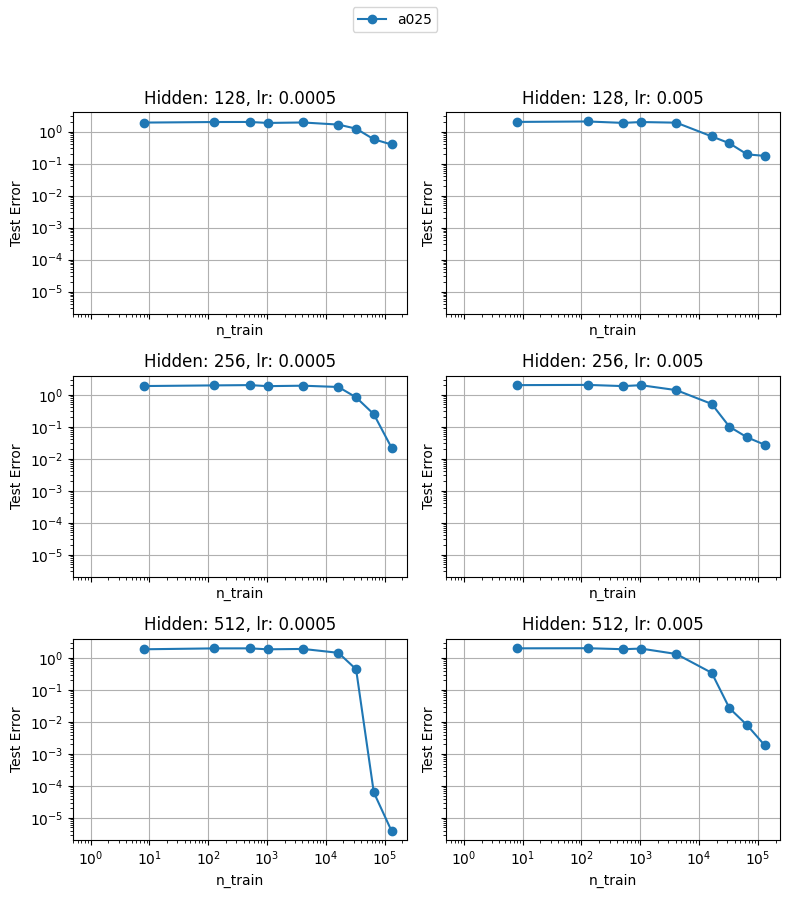

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_testgrid/d10_hidden256_pytorch_2202_loss"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


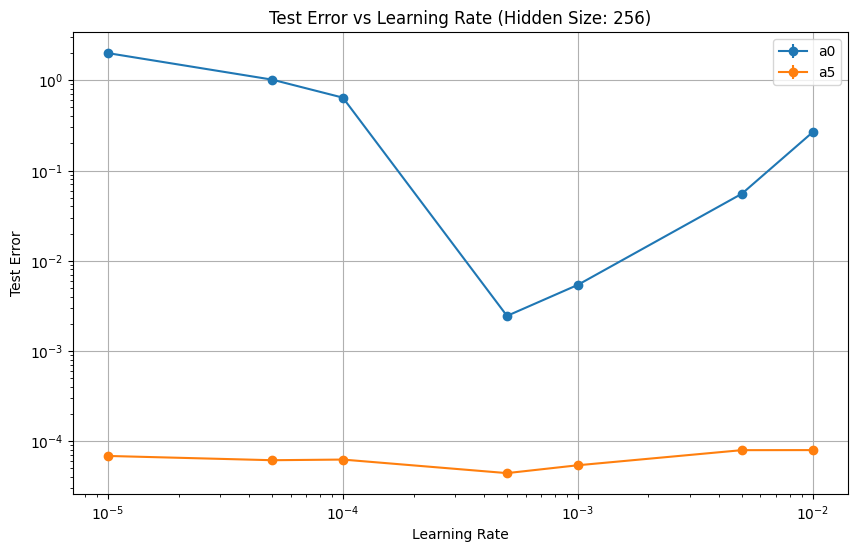

FileNotFoundError: [Errno 2] No such file or directory: ''

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_lr/d10_hidden256_standard_2402_lrgrid_true"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # Set your desired filename here
# File path to save the plot data (JSON)
plot_data_file = ""

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern "results_*.jsonl".
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()
n_train_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
        n_train_set.add(r["n_train"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)
unique_n_train = sorted(n_train_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= PREPARE DATA FOR LEARNING RATE COMPARISON =======
# Structure: lr_data[hidden_size][dataset][learning_rate] = list of test_error values
lr_data = {}

for hs in unique_hidden:
    lr_data[hs] = {}
    for ds in unique_dataset:
        lr_data[hs][ds] = {}
        for lr in unique_lr:
            lr_data[hs][ds][lr] = []

# Populate the data structure
for r in results_depth1:
    try:
        hs = r["hidden_size"]
        ds = r["dataset_name"]
        lr = r["learning_rate"]
        test_error = r["test_error"]
        
        lr_data[hs][ds][lr].append(test_error)
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

# ======= CALCULATE STATISTICS =======
# For each combination, calculate mean and std of test errors
plot_data = []

for hs in unique_hidden:
    for ds in unique_dataset:
        # Prepare data for this hidden size and dataset
        x_vals = []
        y_means = []
        y_stds = []
        
        for lr in unique_lr:
            errors = lr_data[hs][ds][lr]
            if errors:  # Only include if we have data
                x_vals.append(lr)
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
        
        # Save this curve's data
        curve_data = {
            "hidden_size": hs,
            "dataset": ds,
            "learning_rate": x_vals,
            "mean_test_error": y_means,
            "std_test_error": y_stds
        }
        plot_data.append(curve_data)

# ======= CREATE PLOT FOR EACH HIDDEN SIZE =======
for hs in unique_hidden:
    plt.figure(figsize=(10, 6))
    legend_handles = []
    
    for ds in unique_dataset:
        # Find the data for this hidden size and dataset
        ds_data = None
        for data in plot_data:
            if data["hidden_size"] == hs and data["dataset"] == ds:
                ds_data = data
                break
                
        if ds_data and ds_data["learning_rate"]:
            color = dataset_colors[ds]
            x_vals = ds_data["learning_rate"]
            y_means = ds_data["mean_test_error"]
            y_stds = ds_data["std_test_error"]
            
            line = plt.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=ds
            )[0]
            
            legend_handles.append(line)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Learning Rate")
    plt.ylabel("Test Error")
    plt.title(f"Test Error vs Learning Rate (Hidden Size: {hs})")
    plt.grid(True)
    plt.legend(loc="best")
    
    # Save or show the figure
    if save_fig_path:
        filename = f"{os.path.splitext(save_fig_path)[0]}_hidden{hs}{os.path.splitext(save_fig_path)[1]}"
        plt.savefig(filename)
        print(f"Figure saved to {filename}")
    else:
        plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {plot_data_file}")

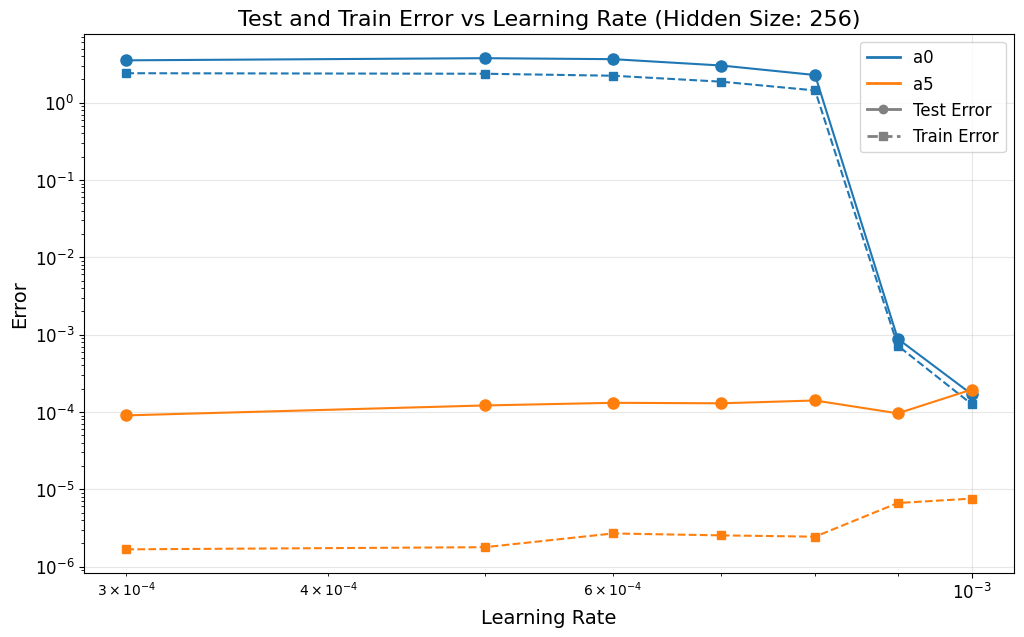

FileNotFoundError: [Errno 2] No such file or directory: ''

In [4]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results_lr/d50_hidden256_standard_2402_lrgrid_true_fine"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # Set your desired filename here
# File path to save the plot data (JSON)
plot_data_file = ""

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern "results_*.jsonl".
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()
n_train_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
        n_train_set.add(r["n_train"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)
unique_n_train = sorted(n_train_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= PREPARE DATA FOR LEARNING RATE COMPARISON =======
# Structure: lr_data[hidden_size][dataset][learning_rate]['test'/'train'] = list of error values
lr_data = {}

for hs in unique_hidden:
    lr_data[hs] = {}
    for ds in unique_dataset:
        lr_data[hs][ds] = {}
        for lr in unique_lr:
            lr_data[hs][ds][lr] = {'test': [], 'train': []}

# Populate the data structure
for r in results_depth1:
    try:
        hs = r["hidden_size"]
        ds = r["dataset_name"]
        lr = r["learning_rate"]
        test_error = r["test_error"]
        train_error = r["final_train_error"]
        
        lr_data[hs][ds][lr]['test'].append(test_error)
        lr_data[hs][ds][lr]['train'].append(train_error)
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

# ======= CALCULATE STATISTICS =======
# For each combination, calculate mean and std of test and train errors
plot_data = []

for hs in unique_hidden:
    for ds in unique_dataset:
        # Prepare data for this hidden size and dataset
        x_vals = []
        y_test_means = []
        y_test_stds = []
        y_train_means = []
        y_train_stds = []
        
        for lr in unique_lr:
            test_errors = lr_data[hs][ds][lr]['test']
            train_errors = lr_data[hs][ds][lr]['train']
            
            if test_errors and train_errors:  # Only include if we have both test and train data
                x_vals.append(lr)
                
                # Calculate statistics for test errors
                test_mean = sum(test_errors) / len(test_errors)
                test_std = np.std(test_errors) if len(test_errors) > 1 else 0
                y_test_means.append(test_mean)
                y_test_stds.append(test_std)
                
                # Calculate statistics for train errors
                train_mean = sum(train_errors) / len(train_errors)
                train_std = np.std(train_errors) if len(train_errors) > 1 else 0
                y_train_means.append(train_mean)
                y_train_stds.append(train_std)
        
        # Save this curve's data
        curve_data = {
            "hidden_size": hs,
            "dataset": ds,
            "learning_rate": x_vals,
            "mean_test_error": y_test_means,
            "std_test_error": y_test_stds,
            "mean_train_error": y_train_means,
            "std_train_error": y_train_stds
        }
        plot_data.append(curve_data)

# ======= CREATE PLOT FOR EACH HIDDEN SIZE =======
for hs in unique_hidden:
    plt.figure(figsize=(12, 7))
    legend_handles = []
    
    for ds in unique_dataset:
        # Find the data for this hidden size and dataset
        ds_data = None
        for data in plot_data:
            if data["hidden_size"] == hs and data["dataset"] == ds:
                ds_data = data
                break
                
        if ds_data and ds_data["learning_rate"]:
            color = dataset_colors[ds]
            x_vals = ds_data["learning_rate"]
            
            # Plot test error
            test_line = plt.errorbar(
                x_vals, ds_data["mean_test_error"], yerr=ds_data["std_test_error"],
                linestyle='-', marker='o', color=color, markersize=8,
                label=f"{ds} (Test)"
            )[0]
            
            # Plot train error with the same color but different line style
            train_line = plt.errorbar(
                x_vals, ds_data["mean_train_error"], yerr=ds_data["std_train_error"],
                linestyle='--', marker='s', color=color, markersize=6,
                label=f"{ds} (Train)"
            )[0]
            
            legend_handles.extend([test_line, train_line])
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Learning Rate", fontsize=14)
    plt.ylabel("Error", fontsize=14)
    plt.title(f"Test and Train Error vs Learning Rate (Hidden Size: {hs})", fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Create a more organized legend
    # Group by dataset for cleaner legend
    from matplotlib.lines import Line2D
    custom_lines = []
    custom_labels = []
    
    # First add dataset colors
    for ds in unique_dataset:
        custom_lines.append(Line2D([0], [0], color=dataset_colors[ds], lw=2))
        custom_labels.append(ds)
    
    # Then add line style indicators
    custom_lines.append(Line2D([0], [0], color='gray', lw=2, linestyle='-', marker='o'))
    custom_labels.append('Test Error')
    custom_lines.append(Line2D([0], [0], color='gray', lw=2, linestyle='--', marker='s'))
    custom_labels.append('Train Error')
    
    plt.legend(custom_lines, custom_labels, loc="best", fontsize=12)
    
    # Improve tick labels
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    # Set better y-limits to focus on the data
    plt.ylim(bottom=min([min(data["mean_train_error"] + data["mean_test_error"]) 
                        for data in plot_data if data["hidden_size"] == hs]) / 2)
    
    # Save or show the figure
    if save_fig_path:
        filename = f"{os.path.splitext(save_fig_path)[0]}_hidden{hs}{os.path.splitext(save_fig_path)[1]}"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {filename}")
    else:
        plt.show()

# ======= SAVE THE PLOT DATA AS JSON =======
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f, indent=2)
print(f"Plot data saved to {plot_data_file}")

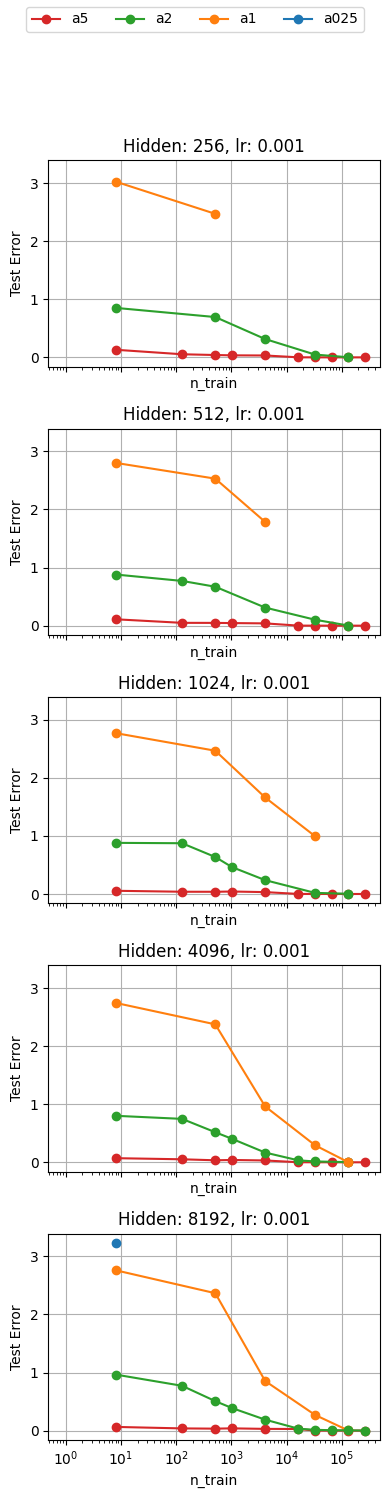

In [4]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_mup_2502"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        #ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

plot normalized loss


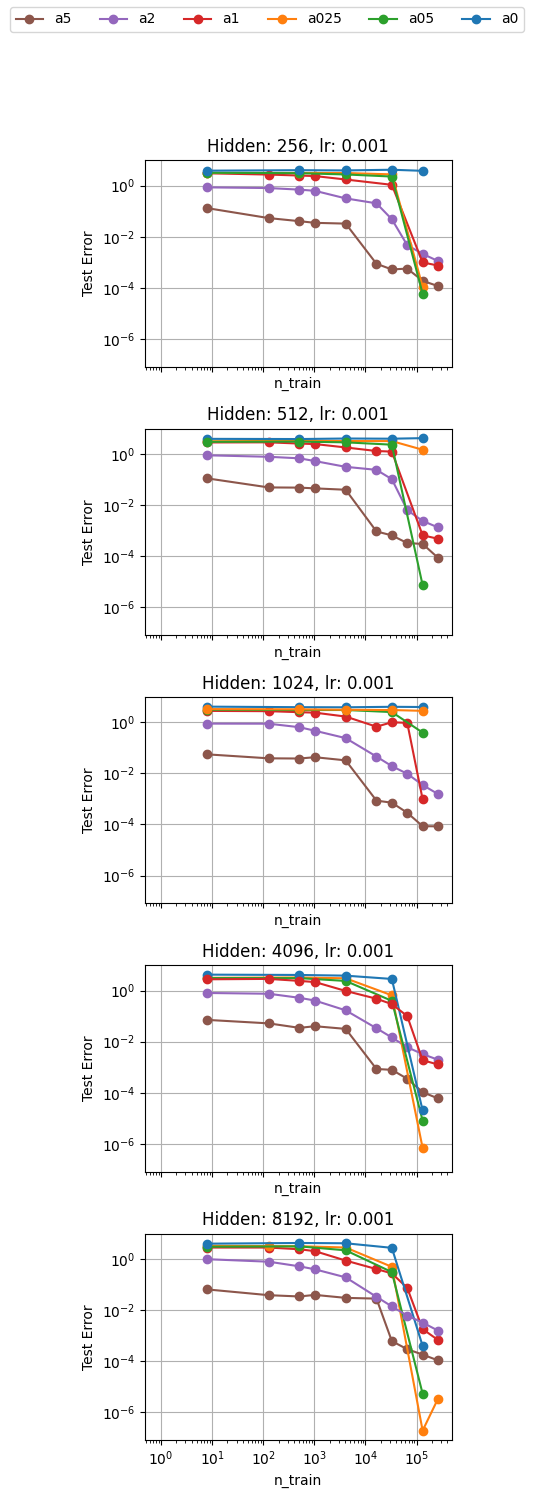

In [23]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======= USER SETTINGS =======
# Set the path to your results directory
results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_mup_2502"
# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

results = load_results(results_directory)
if not results:
    print("No results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
results_depth1 = [r for r in results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS (for depth 1) =======
lr_set = set()
hidden_set = set()
dataset_set = set()

for r in results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted(dataset_set)

# ======= MAP DATASET TO COLOR =======
# Use matplotlib's default color cycle.
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
dataset_colors = {}
for i, ds in enumerate(unique_dataset):
    dataset_colors[ds] = default_colors[i % len(default_colors)]

# ======= GROUP DATA =======
# Structure: group_data[hidden][learning_rate][dataset][n_train] = list of test_error values.
group_data = {}
for hs in unique_hidden:
    group_data[hs] = {}
    for lr in unique_lr:
        group_data[hs][lr] = {}

for r in results_depth1:
    try:
        lr = r["learning_rate"]
        hs = r["hidden_size"]
        dataset = r["dataset_name"]
        n_train = r["n_train"]
        test_error = r["test_error"]
    except KeyError as e:
        print(f"Skipping result due to missing key: {e}")
        continue

    if dataset not in group_data[hs][lr]:
        group_data[hs][lr][dataset] = {}
    if n_train not in group_data[hs][lr][dataset]:
        group_data[hs][lr][dataset][n_train] = []
    group_data[hs][lr][dataset][n_train].append(test_error)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: rows = hidden sizes, columns = learning rates.
n_rows = len(unique_hidden)
n_cols = len(unique_lr)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array.
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# For global legend handles.
legend_handles = {}

for i, hs in enumerate(unique_hidden):
    for j, lr in enumerate(unique_lr):
        ax = axes[i, j]
        data_dict = group_data[hs][lr]
        if not data_dict:
            ax.set_visible(False)
            continue
        # For each dataset group in this subplot.
        for dataset, ntrain_dict in data_dict.items():
            n_train_sorted = sorted(ntrain_dict.keys())
            x_vals = n_train_sorted
            y_means = []
            y_stds = []
            for n in n_train_sorted:
                errors = ntrain_dict[n]
                mean_error = sum(errors) / len(errors)
                std_error = np.std(errors) if len(errors) > 1 else 0
                y_means.append(mean_error)
                y_stds.append(std_error)
            color = dataset_colors[dataset]
            line = ax.errorbar(
                x_vals, y_means, yerr=y_stds,
                linestyle='-', marker='o', color=color, label=f"{dataset}"
            )[0]
            legend_key = dataset
            if legend_key not in legend_handles:
                legend_handles[legend_key] = line
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("n_train")
        ax.set_ylabel("Test Error")
        ax.set_title(f"Hidden: {hs}, lr: {lr}")
        ax.grid(True)

# Create a global legend above the subplots.
fig.legend(legend_handles.values(), legend_handles.keys(), loc="upper center", ncol=len(unique_dataset))
fig.tight_layout(rect=[0, 0, 1, 0.92])

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()


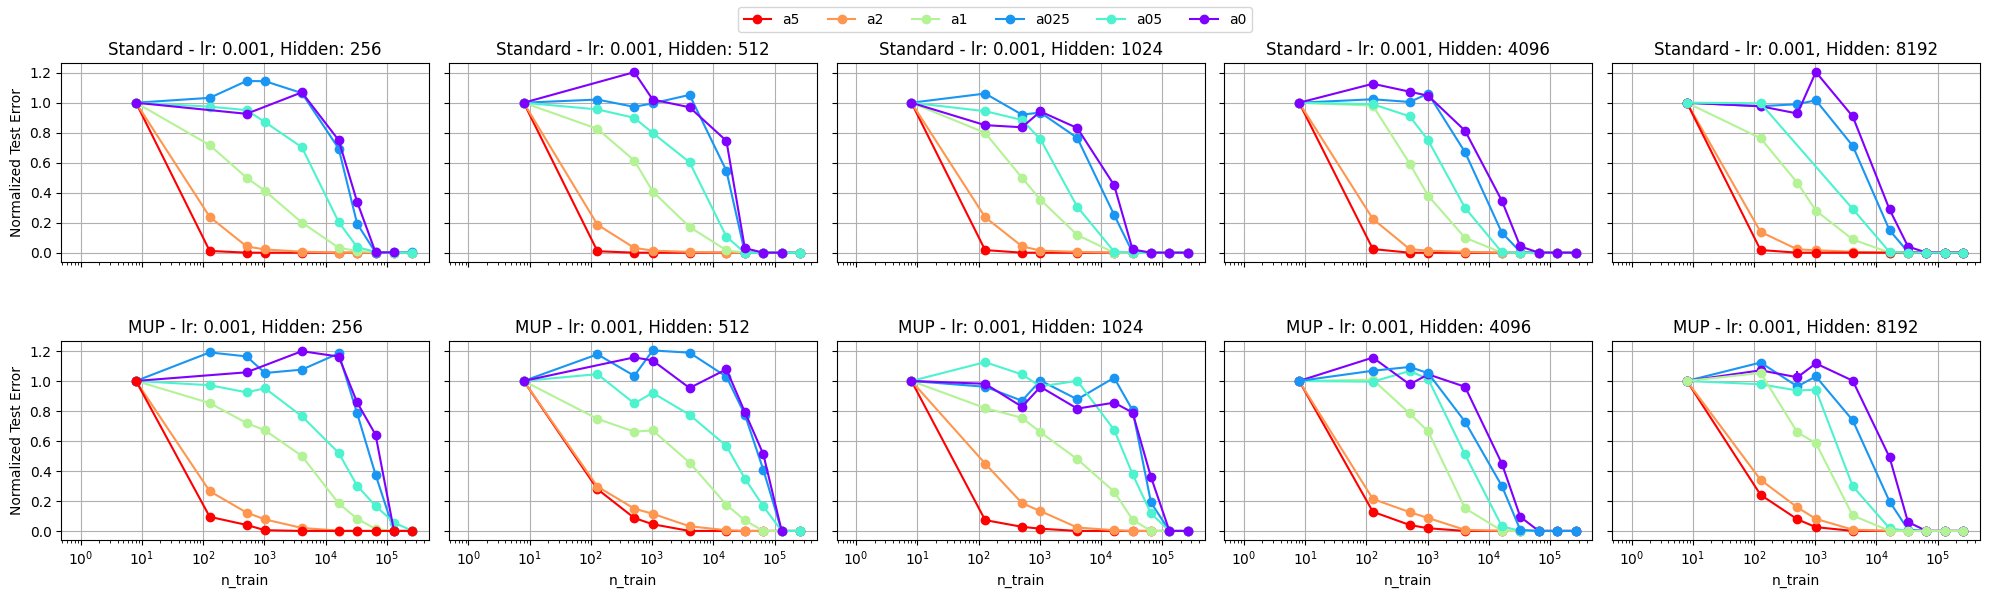

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# ======= USER SETTINGS =======
# Set the paths to your results directories
standard_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d10_hidden256_standard_2502"
mup_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d10_hidden256_mup_2502"

# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# Set to True to normalize all curves to 1 at the first point, False to use raw values
normalize_errors = True  # Toggle normalization on/off

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# Load both sets of results
standard_results = load_results(standard_results_directory)
mup_results = load_results(mup_results_directory)

if not standard_results:
    print("No standard results loaded. Please check the directory path.")
if not mup_results:
    print("No MUP results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
standard_results_depth1 = [r for r in standard_results if r.get("depth") == 1]
mup_results_depth1 = [r for r in mup_results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
hidden_set = set()
dataset_set = set()

# Extract unique parameters from both standard and MUP results
for r in standard_results_depth1 + mup_results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted([d for d in dataset_set if d.startswith('a')])  # Filter for 'a' datasets

# ======= RAINBOW COLOR MAPPING =======
def create_dataset_colors(dataset_names):
    # Get only 'a' datasets
    a_datasets = [ds for ds in dataset_names if ds.startswith('a')]
    
    # Create color dictionary using rainbow colormap
    cmap = plt.get_cmap('rainbow')
    colors = {}
    
    # Define specific dataset order
    dataset_order = ['a0', 'a025', 'a05', 'a1', 'a2', 'a5']
    
    # Assign colors based on position in dataset_order
    for i, dataset in enumerate(dataset_order):
        if dataset in a_datasets:
            # Distribute colors evenly across the rainbow
            colors[dataset] = cmap(i / (len(dataset_order) - 1))
    
    # For any dataset not in our predefined list
    for dataset in a_datasets:
        if dataset not in colors:
            # Try to extract number and position it in the spectrum
            try:
                # For datasets like 'a3' that might not be in our list
                num = float(dataset[1:])
                # Position between 0 and 5 (assuming a0 to a5 range)
                position = min(1.0, max(0.0, num / 5.0))
                colors[dataset] = cmap(position)
            except ValueError:
                # Default for unparseable datasets
                colors[dataset] = cmap(0.5)  # Middle of the rainbow
    
    return colors

# Create color dictionary
dataset_colors = create_dataset_colors(unique_dataset)

# ======= GROUP DATA =======
# Function to group data by parameters
def group_results(results):
    grouped = {}
    for lr in unique_lr:
        grouped[lr] = {}
        for hs in unique_hidden:
            grouped[lr][hs] = {}
    
    for r in results:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            dataset = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError as e:
            print(f"Skipping result due to missing key: {e}")
            continue
        
        if dataset not in unique_dataset:
            continue  # Skip datasets that aren't in the a0-a5 format
            
        if dataset not in grouped[lr][hs]:
            grouped[lr][hs][dataset] = {}
        if n_train not in grouped[lr][hs][dataset]:
            grouped[lr][hs][dataset][n_train] = []
        grouped[lr][hs][dataset][n_train].append(test_error)
    
    return grouped

# Group both sets of results
standard_grouped = group_results(standard_results_depth1)
mup_grouped = group_results(mup_results_depth1)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: 
# - Each column is a different hidden size
# - Each row pair is a learning rate (standard above, MUP below)
n_rows = 2 * len(unique_lr)  # Two rows per learning rate (standard + MUP)
n_cols = len(unique_hidden)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# Create a dictionary to store legend handles
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, hs in enumerate(unique_hidden):
        # Calculate row indices for standard and MUP plots
        standard_row = 2 * i
        mup_row = 2 * i + 1
        
        # Get the axes for standard and MUP plots
        ax_standard = axes[standard_row, j]
        ax_mup = axes[mup_row, j]
        
        # Standard plot
        data_dict = standard_grouped[lr][hs]
        if data_dict:
            for dataset, ntrain_dict in data_dict.items():
                n_train_sorted = sorted(ntrain_dict.keys())
                if not n_train_sorted:
                    continue
                
                x_vals = n_train_sorted
                y_means = []
                y_stds = []
                
                # Calculate means and standard deviations
                for n in n_train_sorted:
                    errors = ntrain_dict[n]
                    mean_error = sum(errors) / len(errors)
                    std_error = np.std(errors) if len(errors) > 1 else 0
                    y_means.append(mean_error)
                    y_stds.append(std_error)
                
                # Normalize errors if normalization is enabled
                first_mean = y_means[0] if y_means else 0
                if normalize_errors and y_means and first_mean > 0:
                    y_means = [err / first_mean for err in y_means]
                    y_stds = [std / first_mean for std in y_stds]
                
                # Get color from viridis map
                color = dataset_colors.get(dataset, 'blue')
                
                # Plot the line
                line = ax_standard.errorbar(
                    x_vals, y_means, yerr=y_stds,
                    linestyle='-', marker='o', color=color, 
                    label=f"{dataset}"
                )[0]
                
                # Store for legend
                legend_key = dataset
                if legend_key not in legend_handles:
                    legend_handles[legend_key] = line
        
        # MUP plot
        data_dict = mup_grouped[lr][hs]
        if data_dict:
            for dataset, ntrain_dict in data_dict.items():
                n_train_sorted = sorted(ntrain_dict.keys())
                if not n_train_sorted:
                    continue
                
                x_vals = n_train_sorted
                y_means = []
                y_stds = []
                
                # Calculate means and standard deviations
                for n in n_train_sorted:
                    errors = ntrain_dict[n]
                    mean_error = sum(errors) / len(errors)
                    std_error = np.std(errors) if len(errors) > 1 else 0
                    y_means.append(mean_error)
                    y_stds.append(std_error)
                
                # Normalize errors so first point is 1
                first_mean = y_means[0]
                if first_mean > 0:  # Avoid division by zero
                    y_means = [err / first_mean for err in y_means]
                    y_stds = [std / first_mean for std in y_stds]
                
                # Get color from viridis map
                color = dataset_colors.get(dataset, 'blue')
                
                # Plot the line
                ax_mup.errorbar(
                    x_vals, y_means, yerr=y_stds,
                    linestyle='-', marker='o', color=color
                )
        
        # Set scales, labels, title for standard plot
        ax_standard.set_xscale("log")
        #ax_standard.set_yscale("log")
        ax_standard.set_title(f"Standard - lr: {lr}, Hidden: {hs}")
        ax_standard.grid(True)
        
        # Only add x-label to bottom row
        if i == len(unique_lr) - 1:
            ax_mup.set_xlabel("n_train")
        
        # Set y-axis label based on normalization
        if j == 0:
            y_label = "Normalized Test Error" if normalize_errors else "Test Error"
            ax_standard.set_ylabel(y_label)
            ax_mup.set_ylabel(y_label)
        
        # Set scales, labels, title for MUP plot
        ax_mup.set_xscale("log")
       #ax_mup.set_yscale("log")
        ax_mup.set_title(f"MUP - lr: {lr}, Hidden: {hs}")
        ax_mup.grid(True)

# Create a global legend above the subplots
fig.legend(
    legend_handles.values(), 
    legend_handles.keys(), 
    loc="upper center", 
    ncol=min(len(legend_handles), 6)
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.90, hspace=0.4)  # Make room for the legend and between rows

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

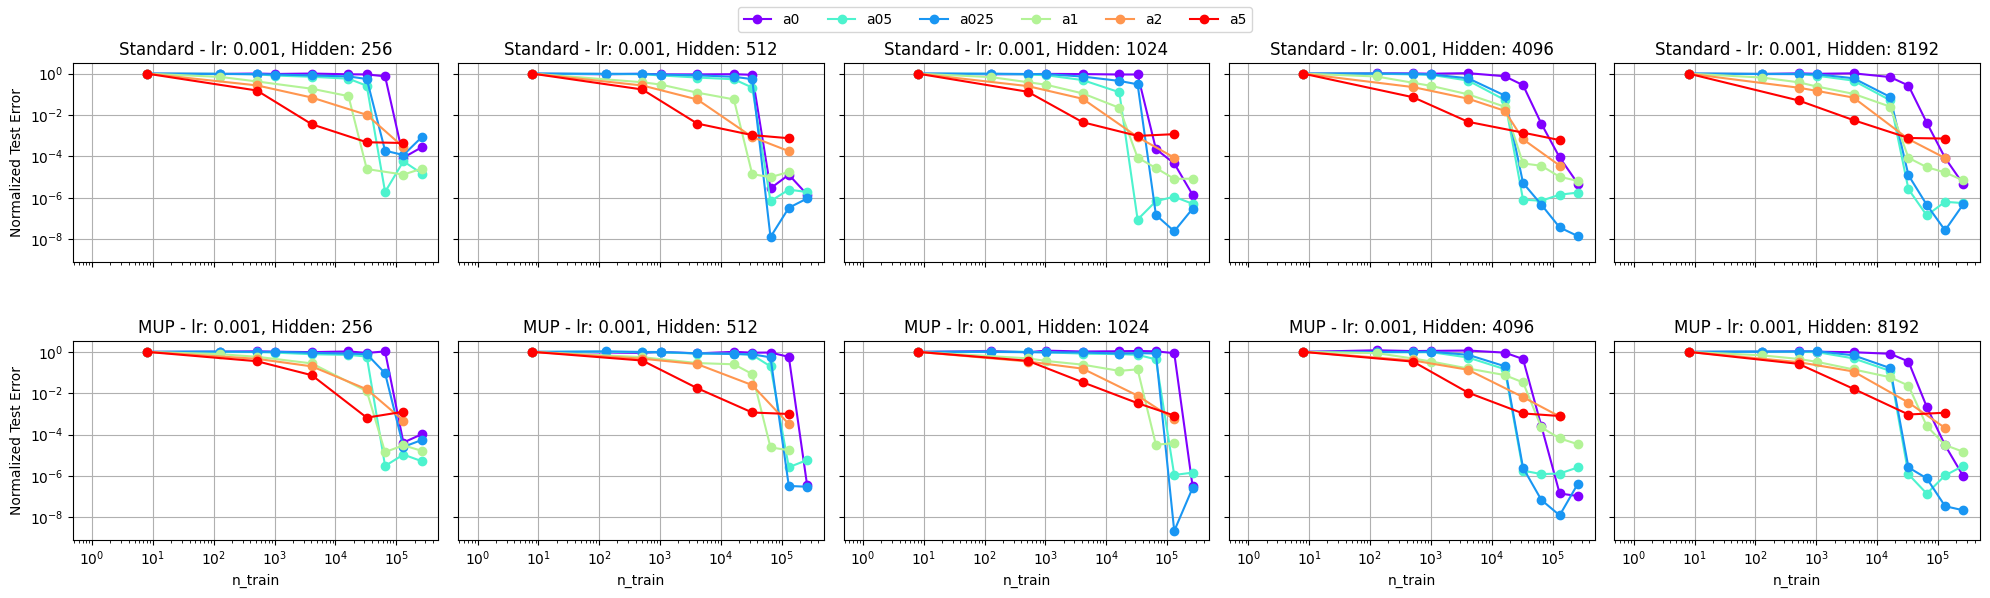

In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# ======= USER SETTINGS =======
# Set the paths to your results directories
standard_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d30_hidden256_standard_2502"
mup_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d30_hidden256_mup_2502"

# If you want to save the figure, specify a file name (e.g., "my_plot.png"); otherwise, leave as an empty string.
save_fig_path = ""  # e.g., "my_plot.png"

# Set to True to normalize all curves to 1 at the first point, False to use raw values
normalize_errors = True  # Toggle normalization on/off

# ======= LOAD RESULTS =======
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# Load both sets of results
standard_results = load_results(standard_results_directory)
mup_results = load_results(mup_results_directory)

if not standard_results:
    print("No standard results loaded. Please check the directory path.")
if not mup_results:
    print("No MUP results loaded. Please check the directory path.")

# ======= FILTER FOR DEPTH 1 NETWORKS =======
standard_results_depth1 = [r for r in standard_results if r.get("depth") == 1]
mup_results_depth1 = [r for r in mup_results if r.get("depth") == 1]

# ======= IDENTIFY UNIQUE PARAMETERS =======
lr_set = set()
hidden_set = set()
dataset_set = set()

# Extract unique parameters from both standard and MUP results
for r in standard_results_depth1 + mup_results_depth1:
    try:
        lr_set.add(r["learning_rate"])
        hidden_set.add(r["hidden_size"])
        dataset_set.add(r["dataset_name"])
    except KeyError as e:
        print(f"Missing key {e} in result: {r}")
        continue

unique_lr = sorted(lr_set)
unique_hidden = sorted(hidden_set)
unique_dataset = sorted([d for d in dataset_set if d.startswith('a')])  # Filter for 'a' datasets

# ======= RAINBOW COLOR MAPPING =======
def create_dataset_colors(dataset_names):
    # Get only 'a' datasets
    a_datasets = [ds for ds in dataset_names if ds.startswith('a')]
    
    # Create color dictionary using rainbow colormap
    cmap = plt.get_cmap('rainbow')
    colors = {}
    
    # Define specific dataset order
    dataset_order = ['a0', 'a025', 'a05', 'a1', 'a2', 'a5']
    
    # Assign colors based on position in dataset_order
    for i, dataset in enumerate(dataset_order):
        if dataset in a_datasets:
            # Distribute colors evenly across the rainbow
            colors[dataset] = cmap(i / (len(dataset_order) - 1))
    
    # For any dataset not in our predefined list
    for dataset in a_datasets:
        if dataset not in colors:
            # Try to extract number and position it in the spectrum
            try:
                # For datasets like 'a3' that might not be in our list
                num = float(dataset[1:])
                # Position between 0 and 5 (assuming a0 to a5 range)
                position = min(1.0, max(0.0, num / 5.0))
                colors[dataset] = cmap(position)
            except ValueError:
                # Default for unparseable datasets
                colors[dataset] = cmap(0.5)  # Middle of the rainbow
    
    return colors

# Create color dictionary
dataset_colors = create_dataset_colors(unique_dataset)

# ======= GROUP DATA =======
# Function to group data by parameters
def group_results(results):
    grouped = {}
    for lr in unique_lr:
        grouped[lr] = {}
        for hs in unique_hidden:
            grouped[lr][hs] = {}
    
    for r in results:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            dataset = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError as e:
            print(f"Skipping result due to missing key: {e}")
            continue
        
        if dataset not in unique_dataset:
            continue  # Skip datasets that aren't in the a0-a5 format
            
        if dataset not in grouped[lr][hs]:
            grouped[lr][hs][dataset] = {}
        if n_train not in grouped[lr][hs][dataset]:
            grouped[lr][hs][dataset][n_train] = []
        grouped[lr][hs][dataset][n_train].append(test_error)
    
    return grouped

# Group both sets of results
standard_grouped = group_results(standard_results_depth1)
mup_grouped = group_results(mup_results_depth1)

# ======= PLOT THE RESULTS =======
# Create a grid of subplots: 
# - Each column is a different hidden size
# - Each row pair is a learning rate (standard above, MUP below)
n_rows = 2 * len(unique_lr)  # Two rows per learning rate (standard + MUP)
n_cols = len(unique_hidden)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# Ensure axes is a 2D array
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = np.array([axes])
elif n_cols == 1:
    axes = np.array([[ax] for ax in axes])

# Create a dictionary to store legend handles
legend_handles = {}

for i, lr in enumerate(unique_lr):
    for j, hs in enumerate(unique_hidden):
        # Calculate row indices for standard and MUP plots
        standard_row = 2 * i
        mup_row = 2 * i + 1
        
        # Get the axes for standard and MUP plots
        ax_standard = axes[standard_row, j]
        ax_mup = axes[mup_row, j]
        
        # Standard plot
        data_dict = standard_grouped[lr][hs]
        if data_dict:
            for dataset, ntrain_dict in data_dict.items():
                n_train_sorted = sorted(ntrain_dict.keys())
                if not n_train_sorted:
                    continue
                
                x_vals = n_train_sorted
                y_means = []
                y_stds = []
                
                # Calculate means and standard deviations
                for n in n_train_sorted:
                    errors = ntrain_dict[n]
                    mean_error = sum(errors) / len(errors)
                    std_error = np.std(errors) if len(errors) > 1 else 0
                    y_means.append(mean_error)
                    y_stds.append(std_error)
                
                # Normalize errors if normalization is enabled
                first_mean = y_means[0] if y_means else 0
                if normalize_errors and y_means and first_mean > 0:
                    y_means = [err / first_mean for err in y_means]
                    y_stds = [std / first_mean for std in y_stds]
                
                # Get color from viridis map
                color = dataset_colors.get(dataset, 'blue')
                
                # Plot the line
                line = ax_standard.errorbar(
                    x_vals, y_means, yerr=y_stds,
                    linestyle='-', marker='o', color=color, 
                    label=f"{dataset}"
                )[0]
                
                # Store for legend
                legend_key = dataset
                if legend_key not in legend_handles:
                    legend_handles[legend_key] = line
        
        # MUP plot
        data_dict = mup_grouped[lr][hs]
        if data_dict:
            for dataset, ntrain_dict in data_dict.items():
                n_train_sorted = sorted(ntrain_dict.keys())
                if not n_train_sorted:
                    continue
                
                x_vals = n_train_sorted
                y_means = []
                y_stds = []
                
                # Calculate means and standard deviations
                for n in n_train_sorted:
                    errors = ntrain_dict[n]
                    mean_error = sum(errors) / len(errors)
                    std_error = np.std(errors) if len(errors) > 1 else 0
                    y_means.append(mean_error)
                    y_stds.append(std_error)
                
                # Normalize errors so first point is 1
                first_mean = y_means[0]
                if first_mean > 0:  # Avoid division by zero
                    y_means = [err / first_mean for err in y_means]
                    y_stds = [std / first_mean for std in y_stds]
                
                # Get color from viridis map
                color = dataset_colors.get(dataset, 'blue')
                
                # Plot the line
                ax_mup.errorbar(
                    x_vals, y_means, yerr=y_stds,
                    linestyle='-', marker='o', color=color
                )
        
        # Set scales, labels, title for standard plot
        ax_standard.set_xscale("log")
        #ax_standard.set_yscale("log")
        ax_standard.set_title(f"Standard - lr: {lr}, Hidden: {hs}")
        ax_standard.grid(True)
        
        # Only add x-label to bottom row
        if i == len(unique_lr) - 1:
            ax_mup.set_xlabel("n_train")
        
        # Set y-axis label based on normalization
        if j == 0:
            y_label = "Normalized Test Error" if normalize_errors else "Test Error"
            ax_standard.set_ylabel(y_label)
            ax_mup.set_ylabel(y_label)
        
        # Set scales, labels, title for MUP plot
        ax_mup.set_xscale("log")
        ax_mup.set_yscale("log")
        ax_mup.set_title(f"MUP - lr: {lr}, Hidden: {hs}")
        ax_mup.grid(True)

# Create a global legend above the subplots
fig.legend(
    legend_handles.values(), 
    legend_handles.keys(), 
    loc="upper center", 
    ncol=min(len(legend_handles), 6)
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.90, hspace=0.4)  # Make room for the legend and between rows

if save_fig_path:
    plt.savefig(save_fig_path)
    print("Figure saved to", save_fig_path)
else:
    plt.show()

/tmp/ipykernel_428828/2239165335.py:297: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(a) for a in alpha_values])
/tmp/ipykernel_428828/2239165335.py:297: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(a) for a in alpha_values])
/tmp/ipykernel_428828/2239165335.py:297: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(a) for a in alpha_values])


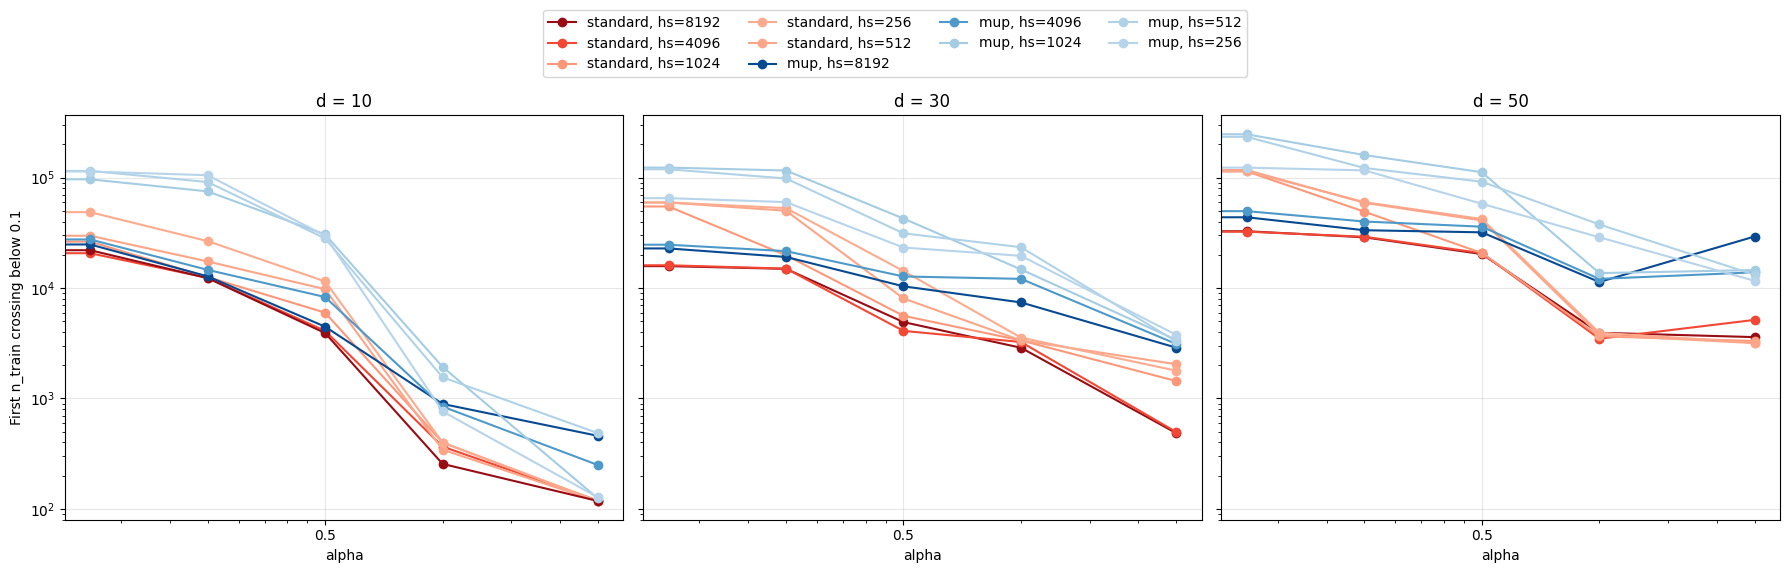

In [1]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# ======== USER SETTINGS ========

# Directories for d=10
STANDARD_DIR_D10 = "/home/goring/TF_spectrum/results/results_correct_scaling/d10_hidden256_standard_2502"
MUP_DIR_D10      = "/home/goring/TF_spectrum/results/results_correct_scaling/d10_hidden256_mup_2502"

# Directories for d=30
STANDARD_DIR_D30 = "/home/goring/TF_spectrum/results/results_correct_scaling/d30_hidden256_standard_2502"
MUP_DIR_D30      = "/home/goring/TF_spectrum/results/results_correct_scaling/d30_hidden256_mup_2502"

# Directories for d=50
STANDARD_DIR_D50 = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_standard_2502"
MUP_DIR_D50      = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_mup_2502"

# If you want to save the figure, set a file name here:
SAVE_FIG_PATH = ""  # e.g. "m_vs_alpha.png"; leave empty to just show the plot.

# If you want the y-axis in log scale, set True
LOG_SCALE_Y = True

ERROR_THRESHOLD = 0.1
DEPTH_FILTER = 1  # We only look at results with depth=1

# A dictionary mapping dataset names to alpha
ALPHA_DICT = {
    "a0":   0.0,
    "a025": 0.25,
    "a05":  0.5,
    "a1":   1.0,
    "a2":   2.0,
    "a5":   5.0,
    # Add more if your data includes other 'a'-datasets
}


# ======== HELPER FUNCTIONS ========

def load_results(directory):
    """
    Loads all JSON lines files from `directory` that match results_*.jsonl.
    Returns a list of dicts (each line is one dict).
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}:\n{line}\nError: {e}")
    return results

def get_alpha_from_dataset(ds_name):
    """
    Uses the ALPHA_DICT to map dataset name (e.g. 'a025') to its alpha float (0.25).
    Returns None if not found in the dictionary.
    """
    return ALPHA_DICT.get(ds_name, None)

def normalize_curve(y_vals):
    """
    Normalize y-values so that the first point is 1.
    If the first value is 0 or empty, just return as-is (or handle differently).
    """
    if not y_vals:
        return y_vals
    first_val = y_vals[0]
    if first_val != 0:
        return [y / first_val for y in y_vals]
    else:
        return y_vals

def find_first_crossing_x(x_vals, y_vals, threshold=0.1):
    """
    Given ascending x_vals and corresponding y_vals, 
    find the first x where y drops below `threshold`.
    
    We do linear interpolation between x[i], x[i+1] if y crosses between consecutive points.
    Returns None if it never goes below `threshold`.
    """
    for i in range(len(y_vals) - 1):
        if y_vals[i] >= threshold and y_vals[i+1] < threshold:
            # linear interpolation
            x0, x1 = x_vals[i], x_vals[i+1]
            y0, y1 = y_vals[i], y_vals[i+1]
            frac = (threshold - y0) / (y1 - y0)
            return x0 + frac * (x1 - x0)
        elif y_vals[i] < threshold:
            # It's already below threshold at x[i]
            return x_vals[i]
    # Check final point
    if len(y_vals) > 0 and y_vals[-1] < threshold:
        return x_vals[-1]
    return None

def process_results(results):
    """
    For each result in `results` (which is a list of dicts), 
    we'll only keep those with depth=DEPTH_FILTER.
    
    We then group them by (hidden_size, dataset_name).
    Each group has a list of (n_train, test_error) pairs.
    
    Returns a dict:
        grouped[(hs, dataset)] = list of (n_train, test_error)
    """
    grouped = {}
    for r in results:
        if r.get("depth") != DEPTH_FILTER:
            continue
        
        hs = r.get("hidden_size")
        ds = r.get("dataset_name")
        ntrain = r.get("n_train")
        test_err = r.get("test_error")
        
        if None in (hs, ds, ntrain, test_err):
            continue
        
        key = (hs, ds)
        if key not in grouped:
            grouped[key] = []
        grouped[key].append((ntrain, test_err))
    return grouped

def compute_m_for_all(grouped, threshold=0.1):
    """
    From the grouped dict, for each (hs, dataset):
      1) sort by n_train,
      2) normalize test_error so first is 1,
      3) find the first crossing below threshold.

    Returns a dict:
        m_values[(hs, dataset)] = crossing_value or None
    """
    m_values = {}
    for key, pairs in grouped.items():
        # sort pairs by n_train
        pairs_sorted = sorted(pairs, key=lambda x: x[0])  # sort by n_train ascending
        n_trains = [p[0] for p in pairs_sorted]
        errors = [p[1] for p in pairs_sorted]
        
        # normalize
        errors_norm = normalize_curve(errors)
        
        # find crossing
        crossing = find_first_crossing_x(n_trains, errors_norm, threshold=threshold)
        m_values[key] = crossing
    return m_values

def process_directory_pair(std_dir, mup_dir):
    """
    Loads the directories for standard vs MUP, 
    groups them, computes m-values, and returns (m_std, m_mup).
    """
    std_res = load_results(std_dir)
    mup_res = load_results(mup_dir)
    
    std_grouped = process_results(std_res)
    mup_grouped = process_results(mup_res)
    
    m_std = compute_m_for_all(std_grouped, threshold=ERROR_THRESHOLD)
    m_mup = compute_m_for_all(mup_grouped, threshold=ERROR_THRESHOLD)
    return m_std, m_mup

# ======== LOAD DATA FOR d=10,30,50 AND COLLECT m VALUES ========

m_std_10, m_mup_10 = process_directory_pair(STANDARD_DIR_D10, MUP_DIR_D10)
m_std_30, m_mup_30 = process_directory_pair(STANDARD_DIR_D30, MUP_DIR_D30)
m_std_50, m_mup_50 = process_directory_pair(STANDARD_DIR_D50, MUP_DIR_D50)

# We'll combine them into a dict for easier plotting
all_m = {
    10: {"standard": m_std_10, "mup": m_mup_10},
    30: {"standard": m_std_30, "mup": m_mup_30},
    50: {"standard": m_std_50, "mup": m_mup_50},
}

# ======== PREPARE PLOTTING (m VS ALPHA) FOR d=10,30,50 ========
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 1) Collect all hidden sizes for Standard & MuP separately
hidden_sizes_std = set()
hidden_sizes_mup = set()

for d_val in all_m:
    # standard
    for (hs, ds) in all_m[d_val]["standard"].keys():
        hidden_sizes_std.add(hs)
    # mup
    for (hs, ds) in all_m[d_val]["mup"].keys():
        hidden_sizes_mup.add(hs)

hidden_sizes_std = sorted(list(hidden_sizes_std))
hidden_sizes_mup = sorted(list(hidden_sizes_mup))

# 2) Determine min & max hidden size for each scaling 
#    (so we map smaller widths to darker color, bigger widths to lighter color)
if hidden_sizes_std:
    minHS_std, maxHS_std = min(hidden_sizes_std), max(hidden_sizes_std)
else:
    minHS_std, maxHS_std = (1, 1)  # fallback if no data

if hidden_sizes_mup:
    minHS_mup, maxHS_mup = min(hidden_sizes_mup), max(hidden_sizes_mup)
else:
    minHS_mup, maxHS_mup = (1, 1)  # fallback if no data

# 3) Define color maps for each scaling
cmap_std = plt.get_cmap("Reds")     # Changed from Oranges to Reds
cmap_mup = plt.get_cmap("Blues")    # Changed from BuGn to Blues

def get_color(scaling, hs):
    """Map `hs` to a fraction [0,1] within that scaling's hidden-size range, then pick from that colormap."""
    if scaling == "standard":
        if maxHS_std == minHS_std:
            frac = 0.5  # if there's only one width
        else:
            frac = (hs - minHS_std) / (maxHS_std - minHS_std)
        # Adjust range to avoid white/too-light colors (0.3 to 0.9 instead of 0 to 1)
        frac = 0.3 + frac * 0.6
        return cmap_std(frac)
    else:  # "mup"
        if maxHS_mup == minHS_mup:
            frac = 0.5
        else:
            frac = (hs - minHS_mup) / (maxHS_mup - minHS_mup)
        # Adjust range to avoid white/too-light colors (0.3 to 0.9 instead of 0 to 1)
        frac = 0.3 + frac * 0.6
        return cmap_mup(frac)

# We'll define the dataset order that we have in ALPHA_DICT,
# and an ordered list of alpha values
dataset_order = list(ALPHA_DICT.keys())  # e.g. ["a0", "a025", "a05", "a1", "a2", "a5"]
alpha_values = [ALPHA_DICT[ds] for ds in dataset_order if ds in ALPHA_DICT and ALPHA_DICT[ds] is not None]

for ax_idx, (d_val, ax) in enumerate(zip([10, 30, 50], axes)):
    ax.set_title(f"d = {d_val}")
    ax.set_xlabel("alpha")
    if LOG_SCALE_Y:
        ax.set_yscale("log")
    if ax_idx == 0:
        ax.set_ylabel(f"First n_train crossing below {ERROR_THRESHOLD}")
    ax.grid(True, alpha=0.3)
    
    # We'll build lines_data for each scaling so we can connect alpha points:
    # lines_data[scaling][hs] = {"alpha": [...], "m": [...]}
    lines_data = {"standard": {}, "mup": {}}
    
    # Collect data
    for scaling in ["standard", "mup"]:
        for (hs, ds), crossing in all_m[d_val][scaling].items():
            alpha_val = get_alpha_from_dataset(ds)
            if alpha_val is None or crossing is None:
                continue  # skip if dataset not recognized or crossing not found
            if hs not in lines_data[scaling]:
                lines_data[scaling][hs] = {"alpha": [], "m": []}
            lines_data[scaling][hs]["alpha"].append(alpha_val)
            lines_data[scaling][hs]["m"].append(crossing)
    
    # Now plot them
    for scaling in ["standard", "mup"]:
        for hs, vals in lines_data[scaling].items():
            alphas_arr = np.array(vals["alpha"])
            m_arr = np.array(vals["m"])
            
            # Sort by alpha so the lines connect in ascending order
            sort_idx = np.argsort(alphas_arr)
            alphas_arr = alphas_arr[sort_idx]
            m_arr = m_arr[sort_idx]
            
            color = get_color(scaling, hs)
            
            ax.plot(
                alphas_arr, m_arr, 
                marker='o',
                color=color,
                label=f"{scaling}, hs={hs}",
                linestyle='-'
            )
    
    # Set the x ticks if you want them specifically for the alpha_values
    ax.set_xticks(alpha_values)
    ax.set_xscale("log")
    ax.set_xticklabels([str(a) for a in alpha_values])

# ======== BUILD A GLOBAL LEGEND (removing duplicates) ========
handles, labels = axes[-1].get_legend_handles_labels()
legend_dict = {}
for h, l in zip(handles, labels):
    if l not in legend_dict:
        legend_dict[l] = h

fig.legend(
    legend_dict.values(), legend_dict.keys(),
    loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.15)
)

fig.tight_layout(rect=[0, 0, 1, 1.0])

if SAVE_FIG_PATH:
    plt.savefig(SAVE_FIG_PATH, dpi=200)
    print(f"Figure saved to {SAVE_FIG_PATH}")
else:
    plt.show()


Loading standard results...
Loaded 231 standard results
Loading MUP results...
Loaded 234 MUP results
Processing standard results...
Processing MUP results...
Extracting standard curves...
Extracting MUP curves...
Fitting standard curves...
Fitting failed for a0 with lr=0.001, hs=8192: `x0` is infeasible.
Fitting failed for a025 with lr=0.001, hs=8192: `x0` is infeasible.
Fitting failed for a05 with lr=0.001, hs=8192: `x0` is infeasible.
Fitted a1 (α=1.0) with lr=0.001, hs=8192: n_c=1399, R²=0.9970
Fitted a5 (α=5.0) with lr=0.001, hs=8192: n_c=157, R²=0.9677
Fitted a2 (α=2.0) with lr=0.001, hs=8192: n_c=347, R²=0.9942
Fitting failed for a0 with lr=0.001, hs=4096: `x0` is infeasible.
Fitting failed for a025 with lr=0.001, hs=4096: `x0` is infeasible.
Fitting failed for a05 with lr=0.001, hs=4096: `x0` is infeasible.
Fitted a1 (α=1.0) with lr=0.001, hs=4096: n_c=1692, R²=0.9953
Fitted a5 (α=5.0) with lr=0.001, hs=4096: n_c=180, R²=0.9876
Fitted a2 (α=2.0) with lr=0.001, hs=4096: n_c=223,

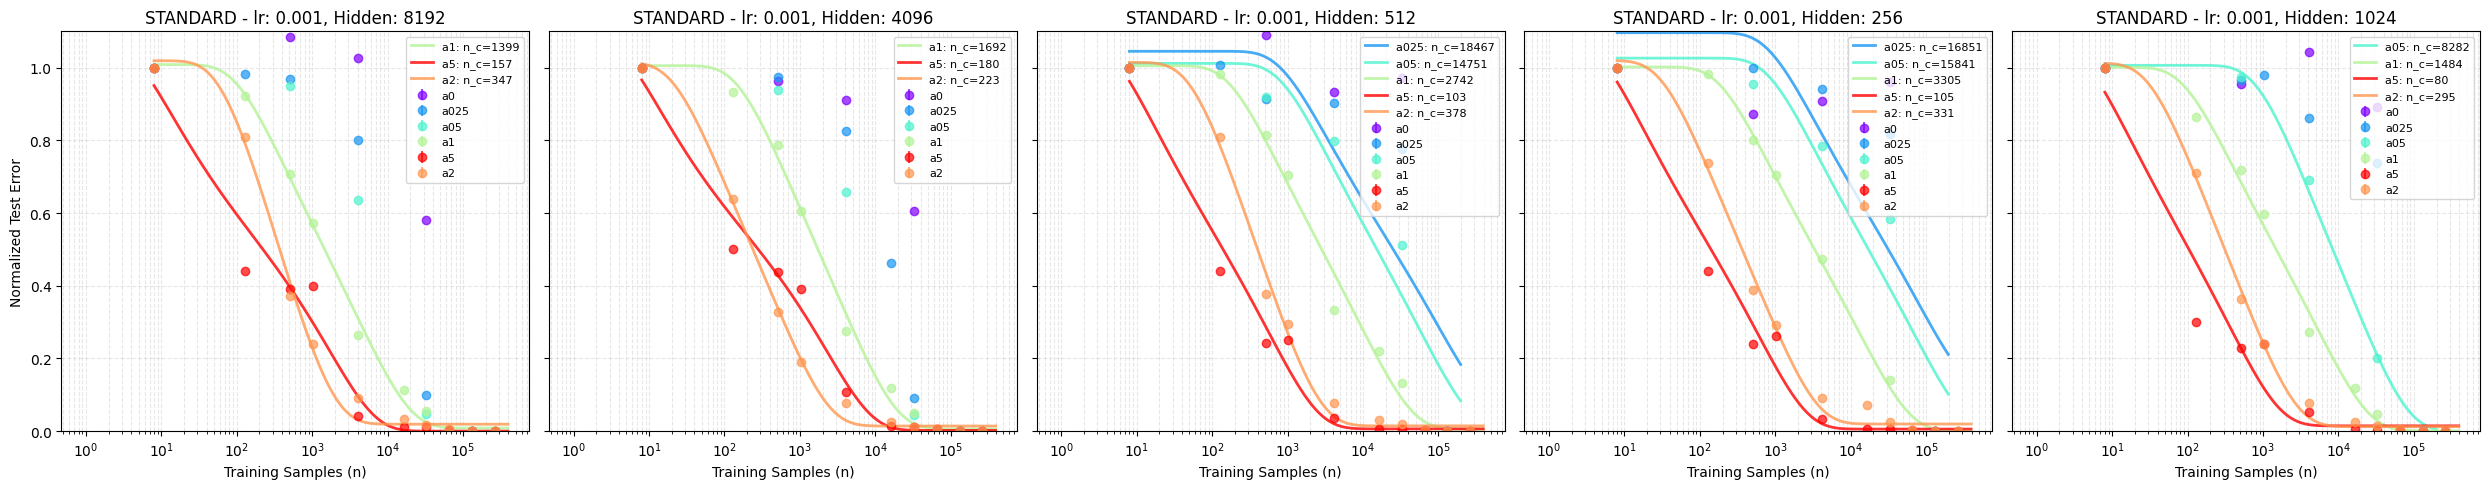

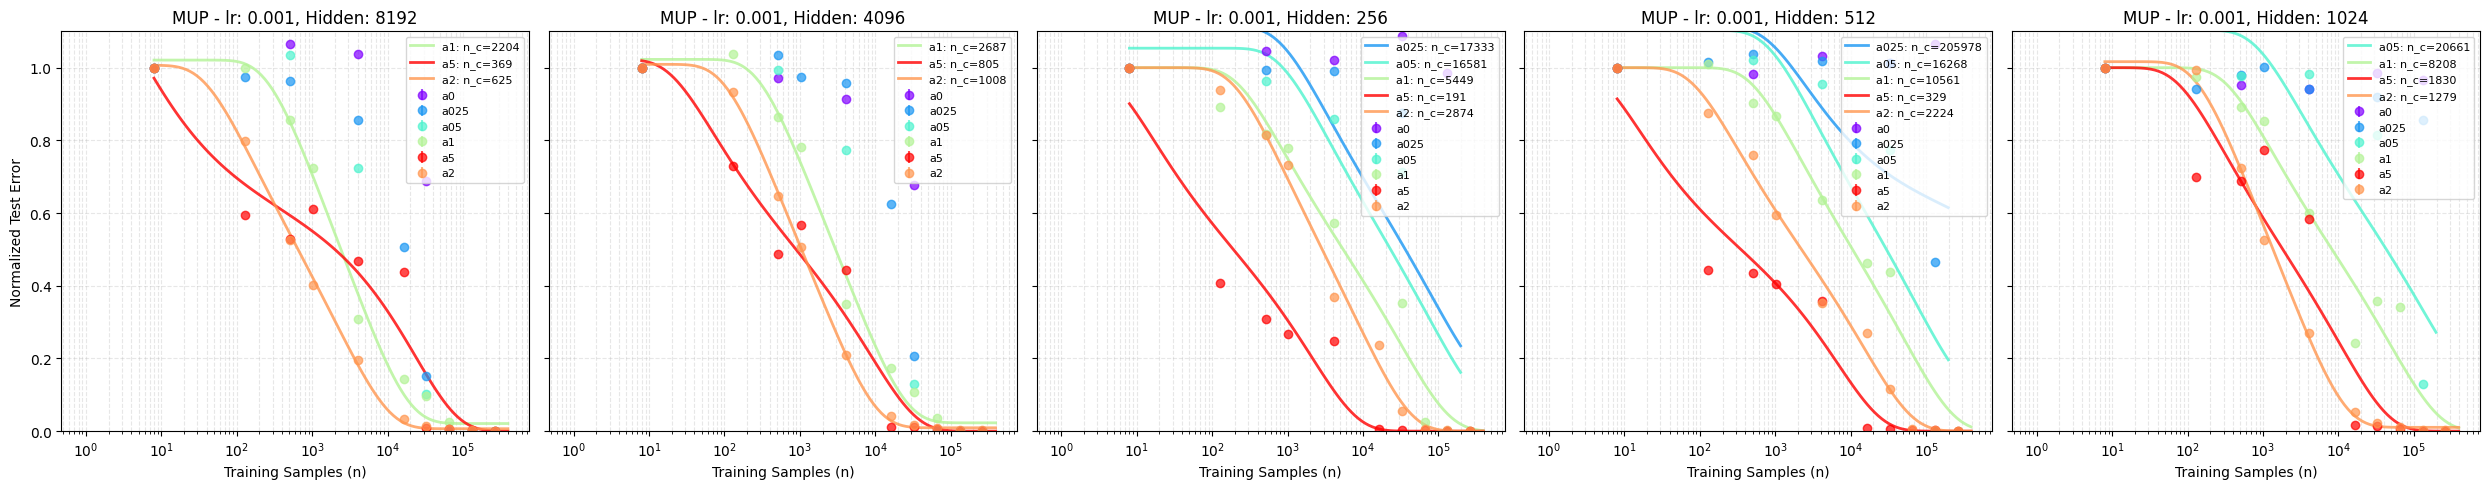

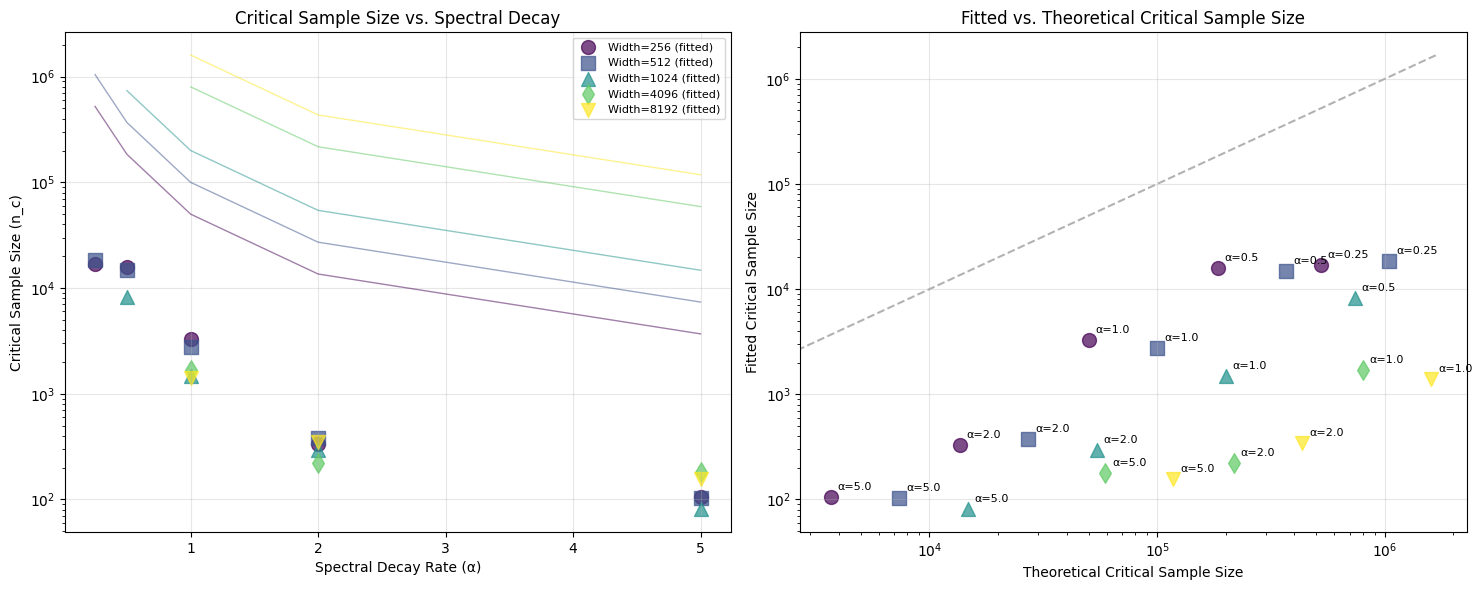

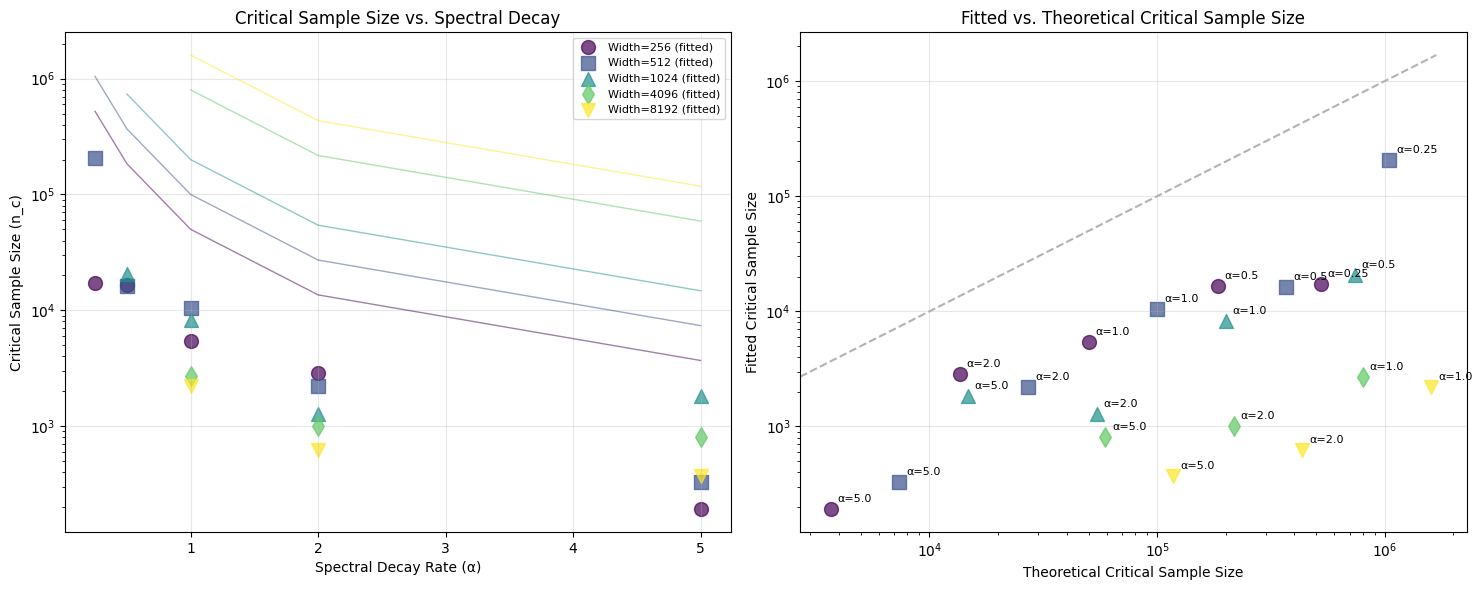

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.optimize import curve_fit
import os
import glob
import json

# Define the phase transition model
def transition_model(n, A, B, C, n_c):
    """
    Phase transition model for learning curves.
    
    Parameters:
    -----------
    n : array_like
        Number of training samples
    A : float
        Asymptotic error (close to 0)
    B : float
        Initial error scaling (close to 1 for normalized errors)
    C : float
        Transition sharpness
    n_c : float
        Critical sample size where transition occurs
        
    Returns:
    --------
    error : array_like
        Predicted test error
    """
    # Prevent division by zero
    n = np.maximum(n, 1e-10)
    
    # Input dimension from the problem
    d = 50
    
    # Calculate the error using the complementary error function
    return A + B * erfc(C * (n/n_c - 1) / np.sqrt(n/d))

# Compute critical sample size based on spectral decay and width
def critical_samples(alpha, width, d=50, base_scale=1000):
    """
    Calculate critical sample size based on spectral decay parameter.
    
    Parameters:
    -----------
    alpha : float
        Spectral decay exponent (0, 0.25, 0.5, 1, 2, 5)
    width : int
        Width of the hidden layer
    d : int
        Input dimension (default: 50)
    base_scale : float
        Base scaling factor (default: 1000)
        
    Returns:
    --------
    n_c : float
        Critical sample size
    """
    # Scale based on theory: n_c ∝ d^(2/(1+α)) * width
    # Base scale chosen to match empirical observations
    width_factor = width / 256  # Normalize to width=256
    return d**(2/(1+alpha)) * base_scale * width_factor

# Load experimental data from JSON Lines files
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    Each line should be a JSON object corresponding to one experimental configuration.
    
    Parameters:
    -----------
    directory : str
        Path to the directory containing result files
        
    Returns:
    --------
    results : list
        List of parsed JSON objects
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {line}\nError: {e}")
    return results

# Process the experimental data
def process_data(results, depth=1):
    """
    Process the loaded results to extract learning curves.
    
    Parameters:
    -----------
    results : list
        List of parsed JSON objects from load_results
    depth : int
        Filter for specific network depth
        
    Returns:
    --------
    processed : dict
        Dictionary organized by learning_rate, hidden_size, and dataset_name
    """
    # Filter by depth
    results_filtered = [r for r in results if r.get("depth") == depth]
    
    # Initialize organization structure
    processed = {}
    
    # Extract unique parameters
    lr_set = set()
    hidden_set = set()
    dataset_set = set()
    
    for r in results_filtered:
        try:
            lr_set.add(r["learning_rate"])
            hidden_set.add(r["hidden_size"])
            dataset_set.add(r["dataset_name"])
        except KeyError as e:
            print(f"Missing key {e} in result")
            continue
    
    # Organize data
    for lr in lr_set:
        processed[lr] = {}
        for hs in hidden_set:
            processed[lr][hs] = {}
            for ds in dataset_set:
                if not ds.startswith('a'):
                    continue  # Skip non-alpha datasets
                processed[lr][hs][ds] = {}
    
    # Fill in data
    for r in results_filtered:
        try:
            lr = r["learning_rate"]
            hs = r["hidden_size"]
            ds = r["dataset_name"]
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError as e:
            continue
        
        if not ds.startswith('a'):
            continue  # Skip non-alpha datasets
            
        if n_train not in processed[lr][hs][ds]:
            processed[lr][hs][ds][n_train] = []
        
        processed[lr][hs][ds][n_train].append(test_error)
    
    return processed

# Extract curve data from processed data
def extract_curves(processed_data, normalize=True):
    """
    Extract curves from processed data.
    
    Parameters:
    -----------
    processed_data : dict
        Dictionary from process_data
    normalize : bool
        Whether to normalize errors to 1 at the first point
        
    Returns:
    --------
    curves : dict
        Dictionary of curves
    """
    curves = {}
    
    for lr, lr_data in processed_data.items():
        curves[lr] = {}
        for hs, hs_data in lr_data.items():
            curves[lr][hs] = {}
            for ds, ds_data in hs_data.items():
                if not ds_data:
                    continue
                
                # Extract n_train and errors
                n_train_values = sorted(ds_data.keys())
                
                if not n_train_values:
                    continue
                
                errors_mean = []
                errors_std = []
                
                for n in n_train_values:
                    errors = ds_data[n]
                    if not errors:
                        continue
                    mean_error = sum(errors) / len(errors)
                    std_error = np.std(errors) if len(errors) > 1 else 0
                    errors_mean.append(mean_error)
                    errors_std.append(std_error)
                
                # Normalize if requested
                if normalize and errors_mean:
                    first_mean = errors_mean[0]
                    if first_mean > 0:
                        errors_mean = [e / first_mean for e in errors_mean]
                        errors_std = [e / first_mean for e in errors_std]
                
                curves[lr][hs][ds] = {
                    'n_train': np.array(n_train_values),
                    'error_mean': np.array(errors_mean),
                    'error_std': np.array(errors_std)
                }
    
    return curves

# Map dataset names to alpha values
def dataset_to_alpha(dataset_name):
    """Map dataset names to alpha values"""
    mapping = {
        'a0': 0.0,
        'a025': 0.25,
        'a05': 0.5,
        'a1': 1.0,
        'a2': 2.0,
        'a5': 5.0
    }
    return mapping.get(dataset_name, None)

# Fit the model to experimental data
def fit_curves(curves, fixed_params=None):
    """
    Fit the transition model to each curve.
    
    Parameters:
    -----------
    curves : dict
        Dictionary of curves from extract_curves
    fixed_params : dict
        Dictionary of parameters to fix (e.g., {'A': 0.0})
        
    Returns:
    --------
    fits : dict
        Dictionary of fitted parameters
    """
    fits = {}
    
    for lr, lr_data in curves.items():
        fits[lr] = {}
        for hs, hs_data in lr_data.items():
            fits[lr][hs] = {}
            for ds, curve in hs_data.items():
                n_train = curve['n_train']
                error_mean = curve['error_mean']
                
                if len(n_train) < 4 or len(error_mean) < 4:
                    print(f"Skipping {ds} with lr={lr}, hs={hs}: not enough data points")
                    continue
                
                # Set initial guess based on data
                alpha = dataset_to_alpha(ds)
                if alpha is None:
                    print(f"Skipping {ds}: unknown alpha value")
                    continue
                
                # Initial parameter guess
                A = 0.0  # Asymptotic error
                B = 1.0  # Initial error (normalized)
                C = 1.0  # Transition sharpness
                
                # Estimate n_c from theory and/or data
                n_c_theory = critical_samples(alpha, int(hs))
                n_c_guess = n_c_theory
                
                # If we have fixed parameters, use them
                if fixed_params:
                    if 'A' in fixed_params:
                        A = fixed_params['A']
                    if 'B' in fixed_params:
                        B = fixed_params['B']
                    if 'C' in fixed_params:
                        C = fixed_params['C']
                
                initial_guess = (A, B, C, n_c_guess)
                
                # Set bounds
                bounds = ([0, 0.5, 0.1, n_train.min()], [0.2, 1.5, 5.0, n_train.max()*10])
                
                # Fit model
                try:
                    popt, pcov = curve_fit(
                        transition_model, n_train, error_mean,
                        p0=initial_guess,
                        bounds=bounds,
                        maxfev=10000
                    )
                    A_fit, B_fit, C_fit, n_c_fit = popt
                    
                    # Calculate R-squared (goodness of fit)
                    y_pred = transition_model(n_train, *popt)
                    ss_tot = np.sum((error_mean - np.mean(error_mean))**2)
                    ss_res = np.sum((error_mean - y_pred)**2)
                    r_squared = 1 - (ss_res / ss_tot)
                    
                    fits[lr][hs][ds] = {
                        'A': A_fit,
                        'B': B_fit,
                        'C': C_fit,
                        'n_c': n_c_fit,
                        'R2': r_squared,
                        'n_c_theory': n_c_theory,
                        'params': popt,
                        'covariance': pcov
                    }
                    
                    print(f"Fitted {ds} (α={alpha}) with lr={lr}, hs={hs}: "
                          f"n_c={n_c_fit:.0f}, R²={r_squared:.4f}")
                    
                except Exception as e:
                    print(f"Fitting failed for {ds} with lr={lr}, hs={hs}: {e}")
    
    return fits

# Plot experimental data with model fits
def plot_experimental_fits(curves, fits, mode='standard', save_path=None):
    """
    Plot experimental data with fitted models.
    
    Parameters:
    -----------
    curves : dict
        Dictionary of curves from extract_curves
    fits : dict
        Dictionary of fitted parameters from fit_curves
    mode : str
        'standard' or 'mup' (for title)
    save_path : str
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Define color map for datasets
    cmap = plt.cm.rainbow
    dataset_order = ['a0', 'a025', 'a05', 'a1', 'a2', 'a5']
    colors = {}
    for i, ds in enumerate(dataset_order):
        colors[ds] = cmap(i / (len(dataset_order) - 1))
    
    # Create figure
    n_lr = len(curves)
    n_hs = max(len(hs_data) for hs_data in curves.values())
    
    fig, axes = plt.subplots(n_lr, n_hs, figsize=(5*n_hs, 5*n_lr), sharex=True, sharey=True)
    
    # Ensure axes is at least 2D
    if n_lr == 1 and n_hs == 1:
        axes = np.array([[axes]])
    elif n_lr == 1:
        axes = np.array([axes])
    elif n_hs == 1:
        axes = np.array([[ax] for ax in axes])
    
    # Plot each learning rate and hidden size combination
    for i, (lr, lr_data) in enumerate(curves.items()):
        for j, (hs, hs_data) in enumerate(lr_data.items()):
            ax = axes[i, j]
            
            # Plot each dataset
            for ds, curve in hs_data.items():
                n_train = curve['n_train']
                error_mean = curve['error_mean']
                error_std = curve['error_std']
                
                color = colors.get(ds, 'blue')
                
                # Plot data points with error bars
                ax.errorbar(
                    n_train, error_mean, yerr=error_std,
                    linestyle='', marker='o', markersize=6,
                    color=color, alpha=0.7, label=ds
                )
                
                # If we have a fit, plot the fitted curve
                if ds in fits.get(lr, {}).get(hs, {}):
                    fit = fits[lr][hs][ds]
                    params = fit['params']
                    
                    # Generate smooth curve for plotting
                    n_dense = np.logspace(np.log10(n_train.min()), np.log10(n_train.max()*1.5), 100)
                    y_fit = transition_model(n_dense, *params)
                    
                    # Plot fitted curve
                    ax.plot(
                        n_dense, y_fit, '-', linewidth=2,
                        color=color, alpha=0.8,
                        label=f"{ds}: n_c={fit['n_c']:.0f}"
                    )
            
            # Set axis properties
            ax.set_xscale('log')
            ax.set_ylim(0, 1.1)
            ax.set_title(f"{mode.upper()} - lr: {lr}, Hidden: {hs}")
            ax.grid(True, which='both', linestyle='--', alpha=0.3)
            
            # Only add labels on edges
            if i == n_lr - 1:
                ax.set_xlabel('Training Samples (n)')
            if j == 0:
                ax.set_ylabel('Normalized Test Error')
            
            # Add legend
            ax.legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Analysis: Compare fitted critical sample sizes with theory
def analyze_critical_samples(fits, save_path=None):
    """
    Analyze the relationship between fitted critical sample sizes and theoretical predictions.
    
    Parameters:
    -----------
    fits : dict
        Dictionary of fitted parameters from fit_curves
    save_path : str
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Collect data for each alpha value
    alphas = []
    n_c_fitted = []
    n_c_theory = []
    hidden_sizes = []
    
    for lr, lr_data in fits.items():
        for hs, hs_data in lr_data.items():
            for ds, fit in hs_data.items():
                alpha = dataset_to_alpha(ds)
                if alpha is not None:
                    alphas.append(alpha)
                    n_c_fitted.append(fit['n_c'])
                    n_c_theory.append(fit['n_c_theory'])
                    hidden_sizes.append(int(hs))
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot critical sample size vs alpha
    unique_hs = sorted(set(hidden_sizes))
    markers = ['o', 's', '^', 'd', 'v', '<', '>', 'p', '*']
    
    for i, hs in enumerate(unique_hs):
        idx = [j for j, h in enumerate(hidden_sizes) if h == hs]
        
        # Get data for this hidden size
        hs_alphas = [alphas[j] for j in idx]
        hs_fitted = [n_c_fitted[j] for j in idx]
        hs_theory = [n_c_theory[j] for j in idx]
        
        # Define marker and color
        marker = markers[i % len(markers)]
        color = plt.cm.viridis(i / max(1, len(unique_hs)-1))
        
        # Sort by alpha
        sorted_idx = np.argsort(hs_alphas)
        hs_alphas = [hs_alphas[j] for j in sorted_idx]
        hs_fitted = [hs_fitted[j] for j in sorted_idx]
        hs_theory = [hs_theory[j] for j in sorted_idx]
        
        # Plot fitted vs alpha
        ax1.scatter(
            hs_alphas, hs_fitted, marker=marker, s=100,
            color=color, label=f'Width={hs} (fitted)',
            alpha=0.7
        )
        
        # Plot theory line
        if len(hs_alphas) > 1:
            ax1.plot(
                hs_alphas, hs_theory, '-', color=color,
                alpha=0.5, linewidth=1
            )
    
    # Set properties for first plot
    ax1.set_xlabel('Spectral Decay Rate (α)')
    ax1.set_ylabel('Critical Sample Size (n_c)')
    ax1.set_title('Critical Sample Size vs. Spectral Decay')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=8)
    
    # Plot fitted vs theoretical
    for i, hs in enumerate(unique_hs):
        idx = [j for j, h in enumerate(hidden_sizes) if h == hs]
        
        # Get data for this hidden size
        hs_fitted = [n_c_fitted[j] for j in idx]
        hs_theory = [n_c_theory[j] for j in idx]
        hs_alphas = [alphas[j] for j in idx]
        
        # Define marker and color
        marker = markers[i % len(markers)]
        color = plt.cm.viridis(i / max(1, len(unique_hs)-1))
        
        # Plot fitted vs theory
        for j, alpha in enumerate(hs_alphas):
            ax2.scatter(
                hs_theory[j], hs_fitted[j], marker=marker, s=100,
                color=color, alpha=0.7
            )
            # Annotate with alpha value
            ax2.annotate(
                f'α={alpha}', 
                (hs_theory[j], hs_fitted[j]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8
            )
    
    # Add diagonal line (perfect prediction)
    lims = [
        min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
        max(ax2.get_xlim()[1], ax2.get_ylim()[1])
    ]
    ax2.plot(lims, lims, 'k--', alpha=0.3, zorder=0)
    
    # Set properties for second plot
    ax2.set_xlabel('Theoretical Critical Sample Size')
    ax2.set_ylabel('Fitted Critical Sample Size')
    ax2.set_title('Fitted vs. Theoretical Critical Sample Size')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Main function to run the entire analysis pipeline
def main(standard_dir, mup_dir, output_dir="phase_transition_analysis"):
    """
    Run the complete analysis pipeline.
    
    Parameters:
    -----------
    standard_dir : str
        Path to standard results directory
    mup_dir : str
        Path to MUP results directory
    output_dir : str
        Directory to save output figures and data
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and process data
    print("Loading standard results...")
    standard_results = load_results(standard_dir)
    print(f"Loaded {len(standard_results)} standard results")
    
    print("Loading MUP results...")
    mup_results = load_results(mup_dir)
    print(f"Loaded {len(mup_results)} MUP results")
    
    # Process data
    print("Processing standard results...")
    standard_processed = process_data(standard_results)
    
    print("Processing MUP results...")
    mup_processed = process_data(mup_results)
    
    # Extract curves
    print("Extracting standard curves...")
    standard_curves = extract_curves(standard_processed)
    
    print("Extracting MUP curves...")
    mup_curves = extract_curves(mup_processed)
    
    # Fit curves
    print("Fitting standard curves...")
    standard_fits = fit_curves(standard_curves)
    
    print("Fitting MUP curves...")
    mup_fits = fit_curves(mup_curves)
    
    # Plot fits
    print("Plotting standard fits...")
    fig_standard = plot_experimental_fits(
        standard_curves, standard_fits, mode='standard',
        save_path=os.path.join(output_dir, "standard_fits.png")
    )
    
    print("Plotting MUP fits...")
    fig_mup = plot_experimental_fits(
        mup_curves, mup_fits, mode='MUP',
        save_path=os.path.join(output_dir, "mup_fits.png")
    )
    
    # Analyze critical sample sizes
    print("Analyzing standard critical sample sizes...")
    fig_standard_analysis = analyze_critical_samples(
        standard_fits,
        save_path=os.path.join(output_dir, "standard_analysis.png")
    )
    
    print("Analyzing MUP critical sample sizes...")
    fig_mup_analysis = analyze_critical_samples(
        mup_fits,
        save_path=os.path.join(output_dir, "mup_analysis.png")
    )
    
    print(f"Analysis complete. Results saved to {output_dir}")
    
    return {
        'standard_curves': standard_curves,
        'mup_curves': mup_curves,
        'standard_fits': standard_fits,
        'mup_fits': mup_fits
    }

# If this script is run directly
if __name__ == "__main__":
    # Set paths to your results directories - update these with your actual paths
    standard_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_standard_2502"
    mup_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_mup_2502"
    
    # Run the analysis
    results = main(standard_results_directory, mup_results_directory)

Loading standard results...
Loaded 240 standard results
Loading MUP results...
Loaded 246 MUP results
Processing standard results...
Processing MUP results...
Extracting standard curves...
Extracting MUP curves...
Directly estimating critical sample sizes for standard...
Dataset a0 (α=0.0) with hidden_size=512: critical n≈131072 (direct estimate)
Dataset a025 (α=0.25) with hidden_size=512: critical n≈131072 (direct estimate)
Dataset a05 (α=0.5) with hidden_size=512: critical n≈131072 (direct estimate)
Dataset a1 (α=1.0) with hidden_size=512: critical n≈4096 (direct estimate)
Dataset a5 (α=5.0) with hidden_size=512: critical n≈128 (direct estimate)
Dataset a2 (α=2.0) with hidden_size=512: critical n≈512 (direct estimate)
Dataset a0 (α=0.0) with hidden_size=8192: critical n≈131072 (direct estimate)
Dataset a025 (α=0.25) with hidden_size=8192: critical n≈16384 (direct estimate)
Dataset a05 (α=0.5) with hidden_size=8192: critical n≈32768 (direct estimate)
Dataset a1 (α=1.0) with hidden_siz

NameError: name 'fits' is not defined

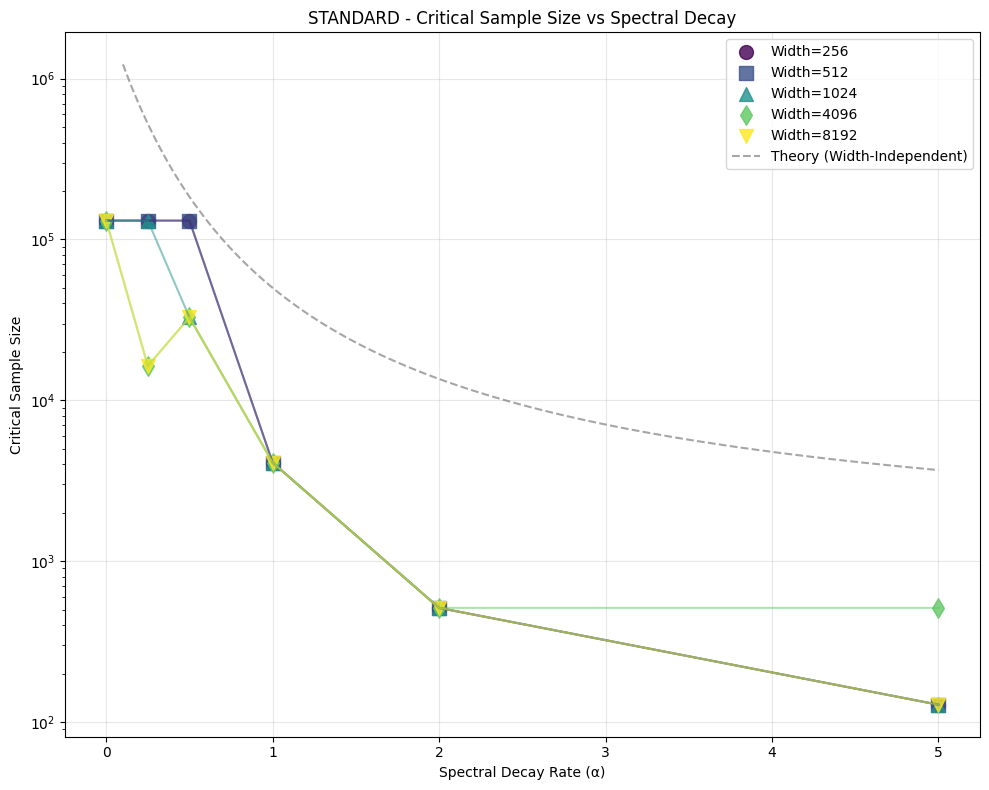

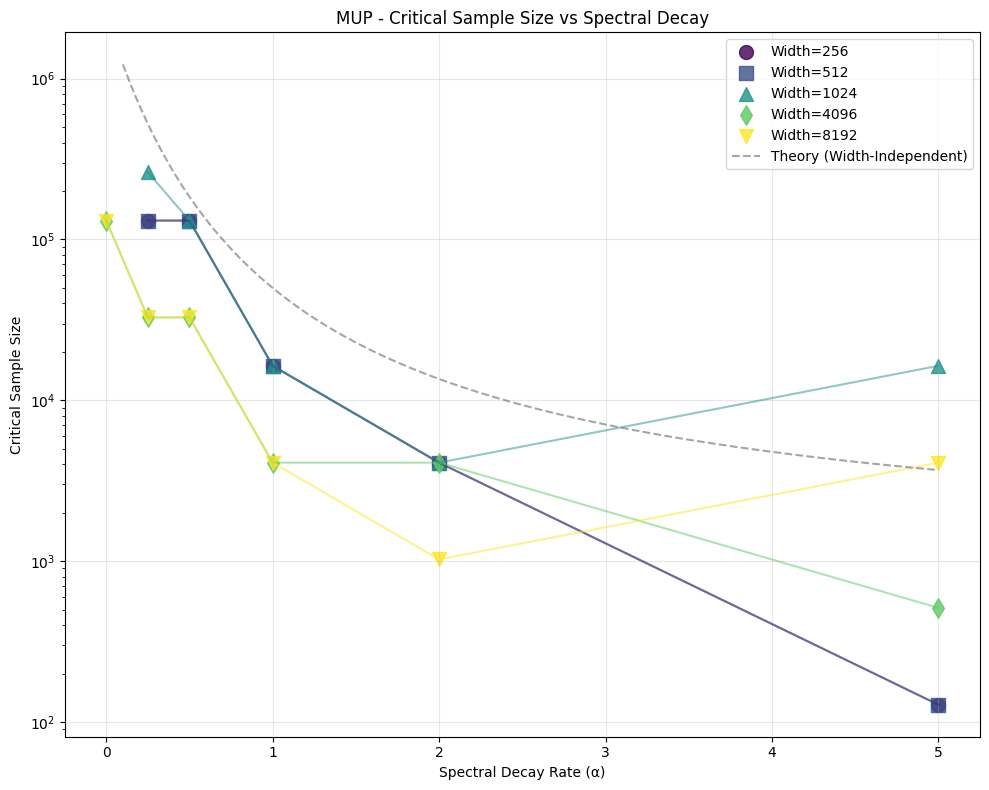

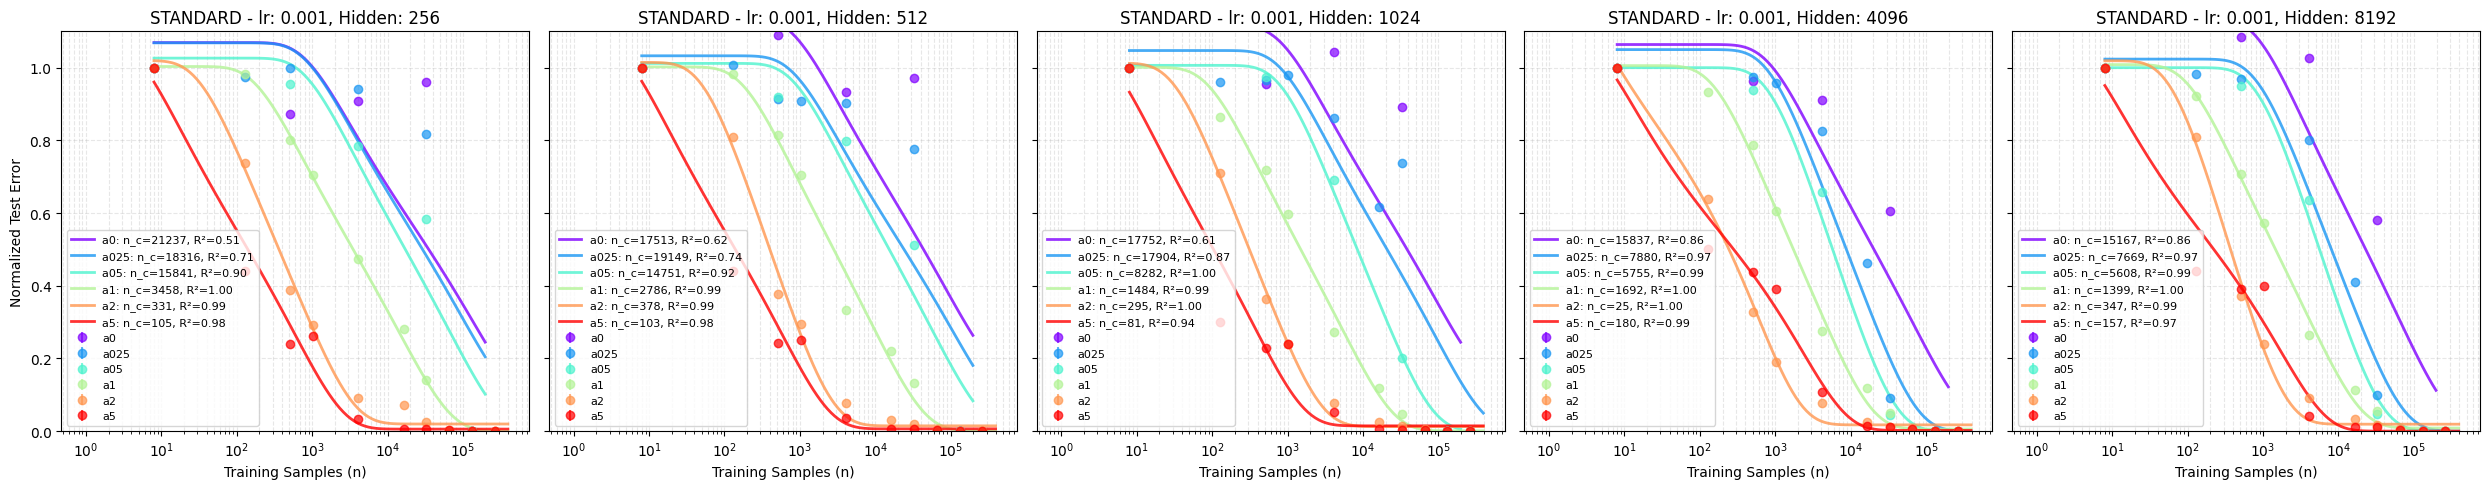

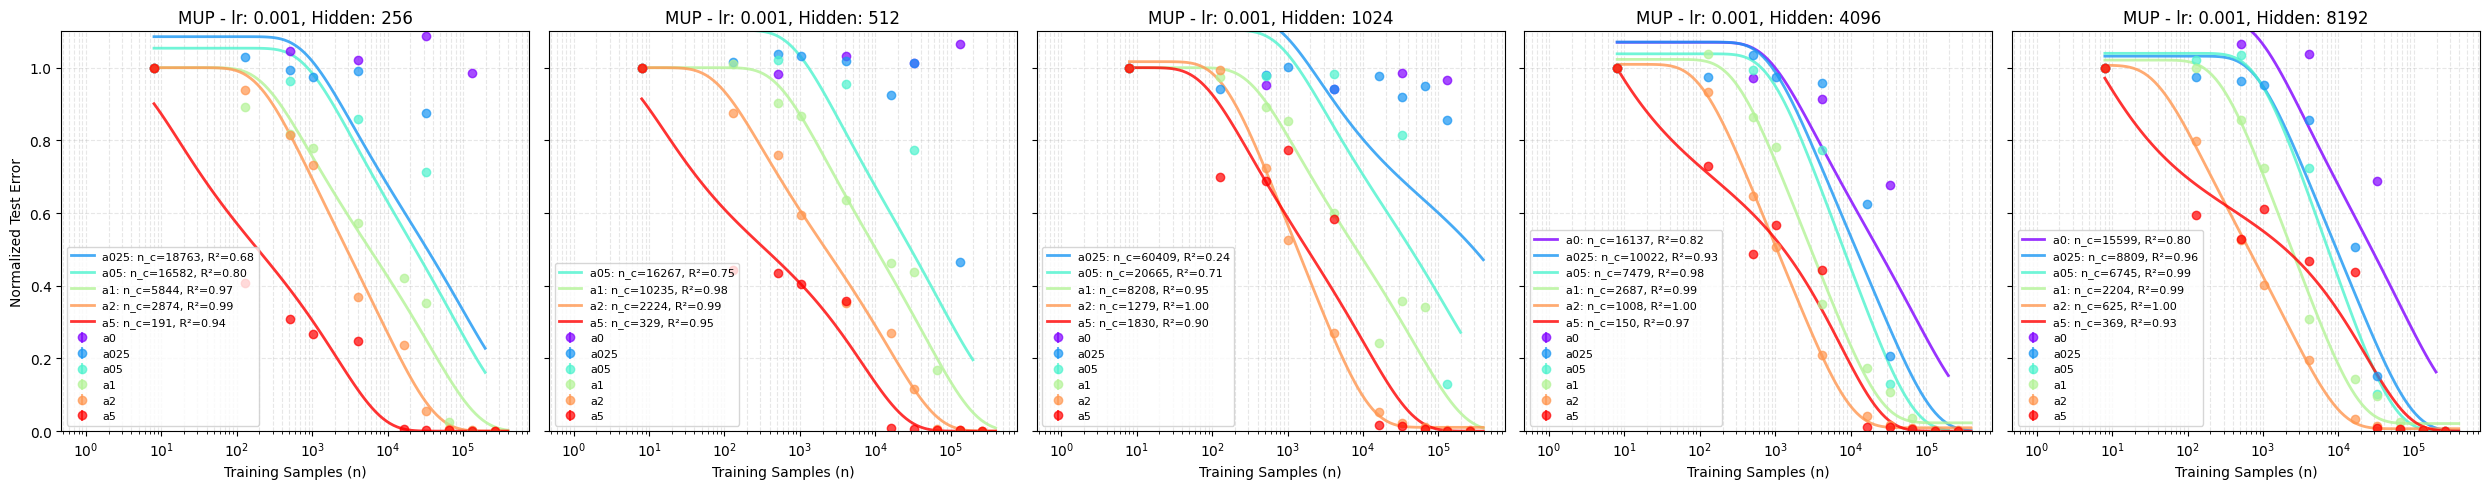

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.optimize import curve_fit
import os
import glob
import json

# Define the revised phase transition model
def transition_model(n, A, B, C, n_c):
    """
    Phase transition model for learning curves - revised to better match empirical observations.
    
    Parameters:
    -----------
    n : array_like
        Number of training samples
    A : float
        Asymptotic error (close to 0)
    B : float
        Initial error scaling (close to 1 for normalized errors)
    C : float
        Transition sharpness
    n_c : float
        Critical sample size where transition occurs
        
    Returns:
    --------
    error : array_like
        Predicted test error
    """
    # Prevent division by zero
    n = np.maximum(n, 1e-10)
    
    # Input dimension from the problem
    d = 50
    
    # Calculate the error using the complementary error function
    return A + B * erfc(C * (n/n_c - 1) / np.sqrt(n/d))

# Compute critical sample size based on spectral decay (width-independent model)
def critical_samples(alpha, d=50, base_scale=1000):
    """
    Calculate critical sample size based solely on spectral decay parameter,
    independent of network width.
    
    Parameters:
    -----------
    alpha : float
        Spectral decay exponent (0, 0.25, 0.5, 1, 2, 5)
    d : int
        Input dimension (default: 50)
    base_scale : float
        Base scaling factor (default: 1000)
        
    Returns:
    --------
    n_c : float
        Critical sample size
    """
    # Modified theory: n_c ∝ d^(2/(1+α))
    return d**(2/(1+alpha)) * base_scale

# Load experimental data from JSON Lines files
def load_results(directory):
    """
    Load all JSON Lines files in the directory that match the pattern *_results_*.jsonl.
    
    Parameters:
    -----------
    directory : str
        Path to the directory containing result files
        
    Returns:
    --------
    results : list
        List of parsed JSON objects
    """
    pattern = os.path.join(directory, "results_*.jsonl")
    files = glob.glob(pattern)
    results = []
    for filename in files:
        with open(filename, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    results.append(data)
                except Exception as e:
                    print(f"Error parsing line in {filename}: {e}")
    return results

# Process the experimental data
def process_data(results, depth=1):
    """
    Process the loaded results to extract learning curves.
    
    Parameters:
    -----------
    results : list
        List of parsed JSON objects from load_results
    depth : int
        Filter for specific network depth
        
    Returns:
    --------
    processed : dict
        Dictionary organized by learning_rate, hidden_size, and dataset_name
    """
    # Filter by depth
    results_filtered = [r for r in results if r.get("depth") == depth]
    
    # Initialize organization structure
    processed = {}
    
    # Extract unique parameters
    lr_set = set()
    hidden_set = set()
    dataset_set = set()
    
    for r in results_filtered:
        try:
            lr_set.add(str(r["learning_rate"]))
            hidden_set.add(str(r["hidden_size"]))
            dataset_set.add(str(r["dataset_name"]))
        except KeyError as e:
            print(f"Missing key {e} in result")
            continue
    
    # Organize data
    for lr in lr_set:
        processed[lr] = {}
        for hs in hidden_set:
            processed[lr][hs] = {}
            for ds in dataset_set:
                if not ds.startswith('a'):
                    continue  # Skip non-alpha datasets
                processed[lr][hs][ds] = {}
    
    # Fill in data
    for r in results_filtered:
        try:
            lr = str(r["learning_rate"])
            hs = str(r["hidden_size"])
            ds = str(r["dataset_name"])
            n_train = r["n_train"]
            test_error = r["test_error"]
        except KeyError as e:
            continue
        
        if not ds.startswith('a'):
            continue  # Skip non-alpha datasets
            
        if n_train not in processed[lr][hs][ds]:
            processed[lr][hs][ds][n_train] = []
        
        processed[lr][hs][ds][n_train].append(test_error)
    
    return processed

# Extract curve data from processed data
def extract_curves(processed_data, normalize=True):
    """
    Extract curves from processed data.
    
    Parameters:
    -----------
    processed_data : dict
        Dictionary from process_data
    normalize : bool
        Whether to normalize errors to 1 at the first point
        
    Returns:
    --------
    curves : dict
        Dictionary of curves
    """
    curves = {}
    
    for lr, lr_data in processed_data.items():
        curves[lr] = {}
        for hs, hs_data in lr_data.items():
            curves[lr][hs] = {}
            for ds, ds_data in hs_data.items():
                if not ds_data:
                    continue
                
                # Extract n_train and errors
                n_train_values = sorted(ds_data.keys())
                
                if not n_train_values:
                    continue
                
                errors_mean = []
                errors_std = []
                
                for n in n_train_values:
                    errors = ds_data[n]
                    if not errors:
                        continue
                    mean_error = sum(errors) / len(errors)
                    std_error = np.std(errors) if len(errors) > 1 else 0
                    errors_mean.append(mean_error)
                    errors_std.append(std_error)
                
                # Normalize if requested
                if normalize and errors_mean:
                    first_mean = errors_mean[0]
                    if first_mean > 0:
                        errors_mean = [e / first_mean for e in errors_mean]
                        errors_std = [e / first_mean for e in errors_std]
                
                curves[lr][hs][ds] = {
                    'n_train': np.array(n_train_values),
                    'error_mean': np.array(errors_mean),
                    'error_std': np.array(errors_std)
                }
    
    return curves

# Map dataset names to alpha values
def dataset_to_alpha(dataset_name):
    """Map dataset names to alpha values"""
    mapping = {
        'a0': 0.0,
        'a025': 0.25,
        'a05': 0.5,
        'a1': 1.0,
        'a2': 2.0,
        'a5': 5.0
    }
    return mapping.get(dataset_name, None)

# Improved function to detect if a curve has a complete transition
def has_complete_transition(n_train, error_mean, threshold=0.4):
    """
    Check if the error curve shows a complete transition.
    Returns True if the error drops below threshold*max_error.
    """
    if len(error_mean) < 3:
        return False
    
    max_error = error_mean[0]
    min_error = np.min(error_mean)
    
    # If error drops to less than threshold of its initial value, 
    # we consider it a complete transition
    return min_error < threshold * max_error

# Fit the transition model to experimental data with width-independent critical sample size
def fit_curves(curves):
    """
    Fit the transition model to each curve.
    
    Parameters:
    -----------
    curves : dict
        Dictionary of curves from extract_curves
        
    Returns:
    --------
    fits : dict
        Dictionary of fitted parameters
    """
    fits = {}
    
    for lr, lr_data in curves.items():
        fits[lr] = {}
        for hs, hs_data in lr_data.items():
            fits[lr][hs] = {}
            for ds, curve in hs_data.items():
                n_train = curve['n_train']
                error_mean = curve['error_mean']
                
                if len(n_train) < 4 or len(error_mean) < 4:
                    print(f"Skipping {ds} with lr={lr}, hs={hs}: not enough data points")
                    continue
                
                # Check if transition is complete within our data range
                complete_transition = has_complete_transition(n_train, error_mean)
                
                if not complete_transition:
                    print(f"Skipping {ds} with lr={lr}, hs={hs}: incomplete transition")
                    continue
                
                # Set initial guess based on data
                alpha = dataset_to_alpha(ds)
                if alpha is None:
                    print(f"Skipping {ds}: unknown alpha value")
                    continue
                
                # Initial parameter guess
                A = 0.0  # Asymptotic error
                B = 1.0  # Initial error (normalized)
                C = 1.0  # Transition sharpness
                
                # Estimate n_c from data - find where error drops to around half of initial
                half_error = 0.5 * error_mean[0]
                idx = np.argmin(np.abs(error_mean - half_error))
                n_c_guess = float(n_train[idx])
                
                # Calculate theoretical n_c (width-independent)
                n_c_theory = critical_samples(alpha)
                
                initial_guess = (A, B, C, n_c_guess)
                
                # Set bounds
                bounds = ([0, 0.5, 0.1, n_train.min()], [0.2, 1.5, 5.0, n_train.max()*10])
                
                # Fit model
                try:
                    popt, pcov = curve_fit(
                        transition_model, n_train, error_mean,
                        p0=initial_guess,
                        bounds=bounds,
                        maxfev=10000
                    )
                    A_fit, B_fit, C_fit, n_c_fit = popt
                    
                    # Calculate R-squared (goodness of fit)
                    y_pred = transition_model(n_train, *popt)
                    ss_tot = np.sum((error_mean - np.mean(error_mean))**2)
                    ss_res = np.sum((error_mean - y_pred)**2)
                    r_squared = 1 - (ss_res / ss_tot)
                    
                    fits[lr][hs][ds] = {
                        'A': A_fit,
                        'B': B_fit,
                        'C': C_fit,
                        'n_c': n_c_fit,
                        'R2': r_squared,
                        'n_c_theory': n_c_theory,
                        'params': popt,
                        'covariance': pcov,
                        'alpha': alpha
                    }
                    
                    print(f"Fitted {ds} (α={alpha}) with lr={lr}, hs={hs}: "
                          f"n_c={n_c_fit:.0f}, R²={r_squared:.4f}")
                    
                except Exception as e:
                    print(f"Fitting failed for {ds} with lr={lr}, hs={hs}: {e}")
    
    return fits

# Plot experimental data with model fits
def plot_experimental_fits(curves, fits, mode='standard', save_path=None):
    """
    Plot experimental data with fitted models.
    
    Parameters:
    -----------
    curves : dict
        Dictionary of curves from extract_curves
    fits : dict
        Dictionary of fitted parameters from fit_curves
    mode : str
        'standard' or 'mup' (for title)
    save_path : str
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Define color map for datasets
    cmap = plt.cm.rainbow
    dataset_order = ['a0', 'a025', 'a05', 'a1', 'a2', 'a5']
    colors = {}
    for i, ds in enumerate(dataset_order):
        colors[ds] = cmap(i / (len(dataset_order) - 1))
    
    # Create figure
    n_lr = len(curves)
    n_hs = max(len(hs_data) for hs_data in curves.values())
    
    fig, axes = plt.subplots(n_lr, n_hs, figsize=(5*n_hs, 5*n_lr), sharex=True, sharey=True)
    
    # Ensure axes is at least 2D
    if n_lr == 1 and n_hs == 1:
        axes = np.array([[axes]])
    elif n_lr == 1:
        axes = np.array([axes])
    elif n_hs == 1:
        axes = np.array([[ax] for ax in axes])
    
    # Plot each learning rate and hidden size combination
    for i, (lr, lr_data) in enumerate(curves.items()):
        for j, (hs, hs_data) in enumerate(sorted(lr_data.items(), key=lambda x: int(x[0]))):
            ax = axes[i, j]
            
            # Plot each dataset
            for ds in dataset_order:
                if ds not in hs_data:
                    continue
                    
                curve = hs_data[ds]
                n_train = curve['n_train']
                error_mean = curve['error_mean']
                error_std = curve['error_std']
                
                color = colors.get(ds, 'blue')
                
                # Plot data points with error bars
                ax.errorbar(
                    n_train, error_mean, yerr=error_std,
                    linestyle='', marker='o', markersize=6,
                    color=color, alpha=0.7, label=ds
                )
                
                # If we have a fit, plot the fitted curve
                if ds in fits.get(lr, {}).get(hs, {}):
                    fit = fits[lr][hs][ds]
                    params = fit['params']
                    
                    # Generate smooth curve for plotting
                    n_dense = np.logspace(np.log10(n_train.min()), np.log10(n_train.max()*1.5), 100)
                    y_fit = transition_model(n_dense, *params)
                    
                    # Plot fitted curve
                    ax.plot(
                        n_dense, y_fit, '-', linewidth=2,
                        color=color, alpha=0.8,
                        label=f"{ds}: n_c={fit['n_c']:.0f}, R²={fit['R2']:.2f}"
                    )
            
            # Set axis properties
            ax.set_xscale('log')
            ax.set_ylim(0, 1.1)
            ax.set_title(f"{mode.upper()} - lr: {lr}, Hidden: {hs}")
            ax.grid(True, which='both', linestyle='--', alpha=0.3)
            
            # Only add labels on edges
            if i == n_lr - 1:
                ax.set_xlabel('Training Samples (n)')
            if j == 0:
                ax.set_ylabel('Normalized Test Error')
            
            # Add legend
            handles, labels = ax.get_legend_handles_labels()
            if handles:
                ax.legend(fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Analysis: Compare fitted critical sample sizes with theory
def analyze_critical_samples(fits, save_path=None):
    """
    Analyze the relationship between fitted critical sample sizes and theoretical predictions.
    
    Parameters:
    -----------
    fits : dict
        Dictionary of fitted parameters from fit_curves
    save_path : str
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Collect data for each alpha value
    alphas = []
    n_c_fitted = []
    n_c_theory = []
    hidden_sizes = []
    
    for lr, lr_data in fits.items():
        for hs, hs_data in lr_data.items():
            for ds, fit in hs_data.items():
                alpha = fit.get('alpha')
                if alpha is not None:
                    alphas.append(alpha)
                    n_c_fitted.append(fit['n_c'])
                    n_c_theory.append(fit['n_c_theory'])
                    hidden_sizes.append(int(hs))
    
    if not alphas:
        print("No data available for critical sample analysis")
        return None
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot critical sample size vs alpha
    unique_hs = sorted(set(hidden_sizes))
    markers = ['o', 's', '^', 'd', 'v', '<', '>', 'p', '*']
    
    for i, hs in enumerate(unique_hs):
        idx = [j for j, h in enumerate(hidden_sizes) if h == hs]
        
        # Get data for this hidden size
        hs_alphas = [alphas[j] for j in idx]
        hs_fitted = [n_c_fitted[j] for j in idx]
        hs_theory = [n_c_theory[j] for j in idx]
        
        # Define marker and color
        marker = markers[i % len(markers)]
        color = plt.cm.viridis(i / max(1, len(unique_hs)-1))
        
        # Sort by alpha
        sorted_idx = np.argsort(hs_alphas)
        hs_alphas = [hs_alphas[j] for j in sorted_idx]
        hs_fitted = [hs_fitted[j] for j in sorted_idx]
        hs_theory = [hs_theory[j] for j in sorted_idx]
        
        # Plot fitted vs alpha
        if hs_alphas:
            ax1.scatter(
                hs_alphas, hs_fitted, marker=marker, s=100,
                color=color, label=f'Width={hs}',
                alpha=0.7
            )
            
            # Connect points if more than one
            if len(hs_alphas) > 1:
                ax1.plot(
                    hs_alphas, hs_fitted, '-', color=color,
                    alpha=0.5, linewidth=1
                )
    
    # Plot theory curves (now width-independent)
    x_dense = np.linspace(0.1, 5, 100)
    theory_values = [critical_samples(alpha) for alpha in x_dense]
    ax1.plot(x_dense, theory_values, '--', color='gray', alpha=0.7, label='Theory (Width-Independent)')
    
    # Set properties for first plot
    ax1.set_xlabel('Spectral Decay Rate (α)')
    ax1.set_ylabel('Critical Sample Size (n_c)')
    ax1.set_title('Critical Sample Size vs. Spectral Decay')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    handles, labels = ax1.get_legend_handles_labels()
    if handles:
        ax1.legend(fontsize=8)
    
    # Plot fitted vs theoretical
    for i, hs in enumerate(unique_hs):
        idx = [j for j, h in enumerate(hidden_sizes) if h == hs]
        
        # Get data for this hidden size
        hs_fitted = [n_c_fitted[j] for j in idx]
        hs_theory = [n_c_theory[j] for j in idx]
        hs_alphas = [alphas[j] for j in idx]
        
        # Define marker and color
        marker = markers[i % len(markers)]
        color = plt.cm.viridis(i / max(1, len(unique_hs)-1))
        
        # Plot fitted vs theory
        for j, alpha in enumerate(hs_alphas):
            ax2.scatter(
                hs_theory[j], hs_fitted[j], marker=marker, s=100,
                color=color, alpha=0.7
            )
            # Annotate with alpha value
            ax2.annotate(
                f'α={alpha}', 
                (hs_theory[j], hs_fitted[j]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8
            )
    
    # Add diagonal line (perfect prediction)
    if ax2.get_xlim()[1] > 0 and ax2.get_ylim()[1] > 0:
        lims = [
            min(ax2.get_xlim()[0], ax2.get_ylim()[0]),
            max(ax2.get_xlim()[1], ax2.get_ylim()[1])
        ]
        ax2.plot(lims, lims, 'k--', alpha=0.3, zorder=0)
    
    # Set properties for second plot
    ax2.set_xlabel('Theoretical Critical Sample Size')
    ax2.set_ylabel('Fitted Critical Sample Size')
    ax2.set_title('Fitted vs. Theoretical Critical Sample Size')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    handles, labels = ax2.get_legend_handles_labels()
    if handles:
        ax2.legend(fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Direct estimation of critical samples from raw data
def estimate_critical_samples(curves, threshold=0.5):
    """
    Directly estimate critical sample sizes from learning curves.
    
    Parameters:
    -----------
    curves : dict
        Dictionary of curves from extract_curves
    threshold : float
        Error threshold as fraction of initial error
        
    Returns:
    --------
    critical_data : dict
        Dictionary of critical sample sizes by hidden size and alpha
    """
    critical_data = {}
    
    for lr, lr_data in curves.items():
        for hs, hs_data in lr_data.items():
            if hs not in critical_data:
                critical_data[hs] = {'alpha': [], 'n_c': []}
                
            for ds, curve in hs_data.items():
                alpha = dataset_to_alpha(ds)
                if alpha is None:
                    continue
                    
                n_train = curve['n_train']
                error_mean = curve['error_mean']
                
                if len(n_train) < 3 or len(error_mean) < 3:
                    continue
                
                # Get initial error
                initial_error = error_mean[0]
                if initial_error <= 0:
                    continue
                
                # Find where error drops below threshold
                for i in range(len(n_train)):
                    if error_mean[i] / initial_error <= threshold:
                        critical_data[hs]['alpha'].append(alpha)
                        critical_data[hs]['n_c'].append(n_train[i])
                        print(f"Dataset {ds} (α={alpha}) with hidden_size={hs}: "
                              f"critical n≈{n_train[i]} (direct estimate)")
                        break
    
    return critical_data

# Plot critical sample size from direct estimates
def plot_critical_samples_direct(critical_data, mode='standard', save_path=None):
    """
    Plot directly estimated critical sample sizes vs alpha.
    
    Parameters:
    -----------
    critical_data : dict
        Dictionary from estimate_critical_samples
    mode : str
        'standard' or 'mup' (for title)
    save_path : str
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define colors and markers for different widths
    hidden_sizes = sorted(critical_data.keys(), key=int)
    colors = plt.cm.viridis(np.linspace(0, 1, len(hidden_sizes)))
    markers = ['o', 's', '^', 'd', 'v']
    
    # Plot each hidden size
    for i, hs in enumerate(hidden_sizes):
        alphas = critical_data[hs]['alpha']
        n_c_values = critical_data[hs]['n_c']
        
        # Skip if no data
        if not alphas:
            continue
            
        # Sort by alpha
        sorted_idx = np.argsort(alphas)
        alphas_sorted = [alphas[j] for j in sorted_idx]
        n_c_sorted = [n_c_values[j] for j in sorted_idx]
        
        # Plot points
        ax.scatter(
            alphas_sorted, n_c_sorted,
            marker=markers[i % len(markers)],
            color=colors[i],
            s=100,
            label=f'Width={hs}',
            alpha=0.8
        )
        
        # Connect points
        if len(alphas_sorted) > 1:
            ax.plot(
                alphas_sorted, n_c_sorted,
                '-', color=colors[i], alpha=0.5
            )
    
    # Plot theory curves (width-independent)
    x_dense = np.linspace(0.1, 5, 100)
    theory_values = [critical_samples(alpha) for alpha in x_dense]
    ax.plot(x_dense, theory_values, '--', color='gray', alpha=0.7, label='Theory (Width-Independent)')
    
    # Set properties
    ax.set_xlabel('Spectral Decay Rate (α)')
    ax.set_ylabel('Critical Sample Size')
    ax.set_title(f'{mode.upper()} - Critical Sample Size vs Spectral Decay')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Main function to run the entire analysis pipeline
def main(standard_dir, mup_dir, output_dir="revised_analysis"):
    """
    Run the complete analysis pipeline with revised model.
    
    Parameters:
    -----------
    standard_dir : str
        Path to standard results directory
    mup_dir : str
        Path to MUP results directory
    output_dir : str
        Directory to save output figures and data
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and process data
    print("Loading standard results...")
    standard_results = load_results(standard_dir)
    print(f"Loaded {len(standard_results)} standard results")
    
    print("Loading MUP results...")
    mup_results = load_results(mup_dir)
    print(f"Loaded {len(mup_results)} MUP results")
    
    # Process data
    print("Processing standard results...")
    standard_processed = process_data(standard_results)
    
    print("Processing MUP results...")
    mup_processed = process_data(mup_results)
    
    # Extract curves
    print("Extracting standard curves...")
    standard_curves = extract_curves(standard_processed)
    
    print("Extracting MUP curves...")
    mup_curves = extract_curves(mup_processed)
    
    # Direct estimation of critical sample sizes (more robust than fitting)
    print("Directly estimating critical sample sizes for standard...")
    standard_critical = estimate_critical_samples(standard_curves)
    
    print("Directly estimating critical sample sizes for MUP...")
    mup_critical = estimate_critical_samples(mup_curves)
    
    # Plot directly estimated critical sample sizes
    print("Plotting critical sample sizes for standard...")
    fig_std_direct = plot_critical_samples_direct(
        standard_critical, mode='standard',
        save_path=os.path.join(output_dir, "standard_critical_direct.png")
    )
    
    print("Plotting critical sample sizes for MUP...")
    fig_mup_direct = plot_critical_samples_direct(
        mup_critical, mode='MUP',
        save_path=os.path.join(output_dir, "mup_critical_direct.png")
    )
    
    # Fit the model to curves (this may be unstable for some curves)
    print("Fitting standard curves with revised model...")
    standard_fits = fit_curves(standard_curves)
    
    print("Fitting MUP curves with revised model...")
    mup_fits = fit_curves(mup_curves)
    
    # Plot learning curves with fits
    print("Plotting standard fits...")
    fig_standard = plot_experimental_fits(
        standard_curves, standard_fits, mode='standard',
        save_path=os.path.join(output_dir, "standard_fits.png")
    )
    
    print("Plotting MUP fits...")
    fig_mup = plot_experimental_fits(
        mup_curves, mup_fits, mode='MUP',
        save_path=os.path.join(output_dir, "mup_fits.png")
    )
    
    # Analyze fitted critical sample sizes (if any fits succeeded)
    if any(fits for _, fits_lr in standard_fits.items() for _, fits_hs in fits_lr.items() for _ in fits_hs.values()):
        print("Analyzing standard critical sample sizes...")
        fig_standard_analysis = analyze_critical_samples(
            standard_fits,
            save_path=os.path.join(output_dir, "standard_analysis.png")
        )
    
    if any(fits for _, fits_lr in mup_fits.items() for _, fits_hs in fits_lr.items() for _ in fits_hs.values()):
        print("Analyzing MUP critical sample sizes...")
        fig_mup_analysis = analyze_critical_samples(
            mup_fits,
            save_path=os.path.join(output_dir, "mup_analysis.png")
        )
    
    print(f"Analysis complete. Results saved to {output_dir}")
    
    return {
        'standard_curves': standard_curves,
        'mup_curves': mup_curves,
        'standard_fits': standard_fits,
        'mup_fits': mup_fits,
        'standard_critical': standard_critical,
        'mup_critical': mup_critical
    }

# If this script is run directly
if __name__ == "__main__":
    # Set paths to your results directories
    standard_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_standard_2502"
    mup_results_directory = "/home/goring/TF_spectrum/results/results_correct_scaling/d50_hidden256_mup_2502"
    
    # Run the analysis
    results = main(standard_results_directory, mup_results_directory)